<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Tutorial-4:-Scheduling-with-CP:-Some-Basics" data-toc-modified-id="Tutorial-4:-Scheduling-with-CP:-Some-Basics-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tutorial 4: Scheduling with CP: Some Basics</a></span><ul class="toc-item"><li><span><a href="#1.-Data" data-toc-modified-id="1.-Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>1. Data</a></span></li><li><span><a href="#2.-Model" data-toc-modified-id="2.-Model-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>2. Model</a></span></li><li><span><a href="#3.-Sandbox" data-toc-modified-id="3.-Sandbox-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>3. Sandbox</a></span></li><li><span><a href="#4.-Conclusion" data-toc-modified-id="4.-Conclusion-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>4. Conclusion</a></span></li></ul></li></ul></div>

BAMRUNG Premchanok 
HUSTACHE Thomas
VALDOM Janvier 2021

# Tutorial 4: Scheduling with CP: Some Basics 

Today we discover a new family of problems, called scheduling. Scheduling problems are widely present in real life applications such as timetabelling, transportation, project management, and manufacturing. We consider a particular problem called the job shop scheduling problem.  In this problem, we are given a set of $n$ jobs: $J_1, J_2, \ldots,  J_n$ and a set of $m$ machines $M_1, M_2, \ldots,  M_m$. 
Each job $J_i$ is defined by a set of $m$ (non-preemptive) tasks $T_{i,1} \ldots T_{i,m}$. Every task $T_{i,k}$ is associated with a duration $p_{i,k}$ and is supposed to be scheduled on machine $M_k$. 

The problem has two sets of constraints: 

 - Precedence constraints: Each job is associated with an order of tasks to respect when scheduling the different tasks.
 - Disjunctive constraints: Each machine can process only one task at a given time


The standard optimisation version of this problem asks to minimize the makespan, i.e., the total scheduling time.


Constraint programming has been widely and successfully used to solve scheduling problems. Many global constraints have been proposed. CP solvers often offer a dedicated library for scheduling. 
Please have a look at the diffrent features proposed in docplex here http://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html?highlight=scheduling#scheduling-functions 


In this tutorial, we will be using (only): 
 - Interval variables for the different variables of the problem:  http://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.expression.py.html?highlight=interval_var#docplex.cp.expression.interval_var
 
 - end_before_start constraints to model precedence constraints : http://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html?highlight=end_before_start#docplex.cp.modeler.end_before_start

- no_overlap global constraint : http://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html?highlight=no_overlap#docplex.cp.modeler.no_overlap


## 1. Data

The format for a job shop scheduling instance respects the following syntax: 
 - The first line containts only $n$ $m$ in this order  ($n$ is the number of jobs and $m$ is the number of machines)
 - Then $n$ lines are given. Each line $i$ is associated to the job $J_i$ and contains exactly $2 m$ integers $x^i_1$ $d^i_1$ $x^i_2$ $d^i_2$ $\ldots$ $x^i_n$ $d^i_n$. Each $x^i_k$ is the $k^{th}$ machine required by the $k^{th}$ task of the job $J_i$, and $d^i_k$ represents its duration. 

Consider for example the data file `instance.data`: 
    
```
 6  6
 2   1  0   3  1   6  3   7  5   3  4   6
 1   8  2   5  4  10  5  10  0  10  3   4
 2   5  3   4  5   8  0   9  1   1  4   7
 1   5  0   5  2   5  3   3  4   8  5   9
 2   9  1   3  4   5  5   4  0   3  3   1
 1   3  3   3  5   9  0  10  4   4  2   1
```

This instance has $6$ jobs and $6$ machines. The first job requires the execution of task $T_{1,2}$ (on machine $2$) of duration $1$, 
then $T_{1,0}$ (on machine $0$) of duration $3$, etc. 

In [1]:
from config import setup
setup()

In [2]:
from docplex.cp.config import context

context.solver.agent = "local"
context.solver.local.execfile = "/home/prembamrung/ibm/ILOG/CPLEX_Studio129/cpoptimizer/bin/x86-64_linux/cpoptimizer"

**Exercice:** Write a simple python code to parse the data file `instance.data`.

In [3]:
import numpy as np

with open("instance.data") as fp:
    Lines = fp.readlines()
data = []
for i in range(len(Lines)):
    toto = Lines[i].strip().split("  ")
    toto = [i.replace(" ", "") for i in toto]
    data.append(toto)

data = np.asarray(data[1:])
data

array([['2', '1', '0', '3', '1', '6', '3', '7', '5', '3', '4', '6'],
       ['1', '8', '2', '5', '4', '10', '5', '10', '0', '10', '3', '4'],
       ['2', '5', '3', '4', '5', '8', '0', '9', '1', '1', '4', '7'],
       ['1', '5', '0', '5', '2', '5', '3', '3', '4', '8', '5', '9'],
       ['2', '9', '1', '3', '4', '5', '5', '4', '0', '3', '3', '1'],
       ['1', '3', '3', '3', '5', '9', '0', '10', '4', '4', '2', '1']],
      dtype='<U2')

**Exercice:** Create a matrix `machines` that satisfies: `machines[i][k]` is the machine of the $k^{th}$ task of job $i$ (one line).

In [4]:
machines = np.zeros((int(len(data[0]) / 2), len(data[:][:])), dtype=int)

for c, i in enumerate(data):
    for cpt, j in enumerate(i):
        if cpt % 2 == 0:
            machines[int(c)][int(cpt / 2)] = int(j)
machines

array([[2, 0, 1, 3, 5, 4],
       [1, 2, 4, 5, 0, 3],
       [2, 3, 5, 0, 1, 4],
       [1, 0, 2, 3, 4, 5],
       [2, 1, 4, 5, 0, 3],
       [1, 3, 5, 0, 4, 2]])

In [5]:
0, 1, 2, 3, 4, 5
3, 6, 1, 7,

(3, 6, 1, 7)

**Exercice:** Create a matrix `durations` that satisfies: `durations[i][k]` is the duration of the $k^{th}$ task of job $i$ (one line)

In [6]:
durations = np.zeros((int(len(data[0]) / 2), len(data[:][:])), dtype=int)

for c, i in enumerate(data):
    for cpt, j in enumerate(i):
        if cpt % 2 == 1:
            durations[int(c)][int(cpt / 2)] = int(j)
durations

array([[ 1,  3,  6,  7,  3,  6],
       [ 8,  5, 10, 10, 10,  4],
       [ 5,  4,  8,  9,  1,  7],
       [ 5,  5,  5,  3,  8,  9],
       [ 9,  3,  5,  4,  3,  1],
       [ 3,  3,  9, 10,  4,  1]])

**Exercice:** Compute a naive upper bound for the makespan. 

**Note:** this upper bound will be used as an upper bound for every interval variable we create.

In [7]:
upper_bound = durations.sum()
upper_bound

197

## 2. Model

**Exercice:** Create a `CpoModel` and the different interval variables you need to solve this problem (do not forget to use the upper bound from the previous question).

In [8]:
from docplex.cp.model import CpoModel
import docplex
import matplotlib.pyplot as plt

**Exercice:** Add the precedence constraints using the [`end_before_start`](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.end_before_start) constraints from `CpoModel`.

In [9]:
mdl = CpoModel(name="tp4")

per_machines = [[] for _ in range(len(durations[0]))]
per_jobs = [[] for _ in durations]


for i, job in enumerate(durations):
    for j, task in enumerate(job):
        v = mdl.interval_var(
            start=(0, upper_bound),
            end=(0, upper_bound),
            length=task,
            name=f"it_{i}_{j}",
        )
        per_machines[machines[i][j]].append(v)
        per_jobs[i].append(v)

per_machines[0], per_jobs[0]

([<docplex.cp.expression.CpoIntervalVar at 0x7f774e3d4170>,
  <docplex.cp.expression.CpoIntervalVar at 0x7f774e3d4560>])

In [10]:
for i in per_jobs:
    for cpt in range(len(i) - 1):
        mdl.add(mdl.end_before_start(i[cpt], i[cpt + 1]))

In [11]:
print(mdl.export_model())

///////////////////////////////////////////////////////////////////////////////
// CPO file generated at 2021.01.14-17:55:28 for model: tp4
// Source file: <ipython-input-9-beac921c5fc7>
///////////////////////////////////////////////////////////////////////////////

//--- Internals ---
internals {
   version(12.8.0.0);
}

//--- Constants ---

//--- Variables ---
#line 3 "<ipython-input-10-f84f9c3f40b4>"
it_0_0 = intervalVar(start=0..197, end=0..197, length=1);
it_0_1 = intervalVar(start=0..197, end=0..197, length=3);
it_0_2 = intervalVar(start=0..197, end=0..197, length=6);
it_0_3 = intervalVar(start=0..197, end=0..197, length=7);
it_0_4 = intervalVar(start=0..197, end=0..197, length=3);
it_0_5 = intervalVar(start=0..197, end=0..197, length=6);
it_1_0 = intervalVar(start=0..197, end=0..197, length=8);
it_1_1 = intervalVar(start=0..197, end=0..197, length=5);
it_1_2 = intervalVar(start=0..197, end=0..197, length=10);
it_1_3 = intervalVar(start=0..197, end=0..197, length=10);
it_1_4 = i

In [12]:
print("\nSolving model....")
msol = mdl.solve(TimeLimit=10)
print("done")
msol.print_solution()
msol


Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 30, variables: integer: 0, interval: 36, sequence: 0
Solve status: Feasible, Fail status: SearchHasNotFailed
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.0 sec
-------------------------------------------------------------------------------

it_0_0: (start=0, end=1, size=1, length=1)
it_0_1: (start=1, end=4, size=3, length=3)
it_0_2: (start=4, end=10, size=6, length=6)
it_0_3: (start=10, end=17, size=7, length=7)
it_0_4: (start=17, end=20, size=3, length=3)
it_0_5: (start=20, end=26, size=6, length=6)
it_1_0: (start=0, end=8, size=8, length=8)
it_1_1: (start=8, end=13, size=5, length=5)
it_1_2: (start=13, end=23, size=10, length=10)
it_1_3: (start=23, end=33, size=10, length=10)
it_1_4: (start=33, end=43, size=10, length=10)
it_1_5: (start=43, end=47, size=4, length=4)
it_2_0: (start=0, end=5, size=5, length=5)
it_2_1: (start=5, 

**Exercice:** Post the disjunctive constraints using the [`no_overlap`](https://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html#docplex.cp.modeler.no_overlap) constraints from `CpoModel`.

In [13]:
for i in np.array(per_machines).T:
    mdl.add(mdl.no_overlap(i))

**Exercice:** Create a makespan interval variable and link it to some variables using the [`max`](http://ibmdecisionoptimization.github.io/docplex-doc/cp/docplex.cp.modeler.py.html?highlight=max#docplex.cp.modeler.max) global constraint.

In [14]:
makespan = mdl.max([mdl.end_of(jobit[-1]) for jobit in per_jobs])
makespan

**Exercice:** Add the makespan as an objective function.

In [15]:
mdl.add(mdl.minimize(makespan))

In [16]:
print(mdl.export_model())

///////////////////////////////////////////////////////////////////////////////
// CPO file generated at 2021.01.14-17:55:28 for model: tp4
// Source file: <ipython-input-9-beac921c5fc7>
///////////////////////////////////////////////////////////////////////////////

//--- Internals ---
internals {
   version(12.8.0.0);
}

//--- Constants ---

//--- Variables ---
#line 3 "<ipython-input-10-f84f9c3f40b4>"
it_0_0 = intervalVar(start=0..197, end=0..197, length=1);
it_0_1 = intervalVar(start=0..197, end=0..197, length=3);
it_0_2 = intervalVar(start=0..197, end=0..197, length=6);
it_0_3 = intervalVar(start=0..197, end=0..197, length=7);
it_0_4 = intervalVar(start=0..197, end=0..197, length=3);
it_0_5 = intervalVar(start=0..197, end=0..197, length=6);
it_1_0 = intervalVar(start=0..197, end=0..197, length=8);
it_1_1 = intervalVar(start=0..197, end=0..197, length=5);
it_1_2 = intervalVar(start=0..197, end=0..197, length=10);
it_1_3 = intervalVar(start=0..197, end=0..197, length=10);
it_1_4 = i

In [17]:
machines

array([[2, 0, 1, 3, 5, 4],
       [1, 2, 4, 5, 0, 3],
       [2, 3, 5, 0, 1, 4],
       [1, 0, 2, 3, 4, 5],
       [2, 1, 4, 5, 0, 3],
       [1, 3, 5, 0, 4, 2]])

**Exercice:** Solve this instance. What is the value of the makespan you found? You can print the solution in a format that is easy to see visually.  

In [18]:
print("\nSolving model....")
msol = mdl.solve(TimeLimit=10)
print("done")
msol.print_solution()


Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 36, variables: integer: 0, interval: 36, sequence: 6
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.0 sec
-------------------------------------------------------------------------------
Objective values: (47,), bounds: (47,), gaps: (0,)
it_0_0: (start=0, end=1, size=1, length=1)
it_0_1: (start=1, end=4, size=3, length=3)
it_0_2: (start=4, end=10, size=6, length=6)
it_0_3: (start=10, end=17, size=7, length=7)
it_0_4: (start=17, end=20, size=3, length=3)
it_0_5: (start=20, end=26, size=6, length=6)
it_1_0: (start=0, end=8, size=8, length=8)
it_1_1: (start=8, end=13, size=5, length=5)
it_1_2: (start=13, end=23, size=10, length=10)
it_1_3: (start=23, end=33, size=10, length=10)
it_1_4: (start=33, end=43, size=10, length=10)
it_1_5: (start=43, end=47, size=4, length=4)
it_2_0:

**Exercice:** Factorise your code so that it takes as input the data file and it solves the problem. Try to use few other instances https://github.com/tamy0612/JSPLIB/tree/master/instances

In [19]:
import numpy as np
from docplex.cp.model import CpoModel
import docplex
from os import listdir
from os.path import isfile, join
import numpy as np

# Get the instances path
# Change the path if neeeded


def get_numeric(line):
    """Return only number from a list

    Args:
        line (list): list of string

    Returns:
        list: list of string with only number
    """
    result = []
    for l in line:
        if l.isnumeric():
            result.append(str(l))
    return result


def read_instance(file):
    """Read an instance and return a data matrix

    Args:
        file (instance file): opened instance

    Returns:
        [np.ndarray]: [np array of the value inside the instance file]
    """
    with open(file) as fp:
        lines = fp.readlines()

    if lines[0][0] == "#":
        lines = lines[5:]
    else:
        lines = lines[1:]

    data = []

    for i in range(len(lines)):
        toto = lines[i].strip().split(" ")
        data.append(get_numeric(toto))

    data = np.array(data)
    return data


def get_files(path):
    """Get all the instance files from a directory

    Args:
        path (str): path of all the instances

    Returns:
        files (list): list of all direct path of the instance file
    """
    files = [f for f in listdir(path) if isfile(join(path, f))]
    files = [path + "/" + file for file in files]
    return files


def get_machines(data):
    """Get all the machines used in an instance data matrix

    Args:
        data (np.ndarray): np array of an instance opened with read_instance()

    Returns:
        np.ndarray: np array with only the machines used
    """
    machines = np.zeros((len(data[:][:]), int(len(data[0]) / 2)), dtype=int)
    for c, i in enumerate(data):
        for index, j in enumerate(i):
            if index % 2 == 0:
                machines[int(c)][int(index / 2)] = int(j)
    return np.array(machines, dtype=int)


def get_duration(data):
    """Get all durations used in an instance data matrix

    Args:
        data (np.ndarray): np array of an instance opeend with read_instance()

    Returns:
        np.ndarray: np array with only the durations
    """
    durations = np.zeros((len(data[:][:]), int(len(data[0]) / 2)), dtype=int)
    for c, i in enumerate(data):
        for index, j in enumerate(i):
            if index % 2 == 1:
                durations[int(c)][int(index / 2)] = int(j)
    return np.array(durations, dtype=int)


def solver(machines, duration):
    """Solve a scheduling problem using what was done in the lab

    Args:
        machines (np.ndarray): machines np array from get_machines()
        duration (np.ndarray): duration np array from get_duration()

    Returns:
        solution and nb_instance: solution of the scheduling problem with the number of instances
    """

    print(machines[0])
    upper_bound = int(duration.sum())
    print(upper_bound)
    nb_instance = 0
    # Par machine et par job
    mdl = CpoModel(name="tp4")
    per_machines = [[] for _ in range(len(duration[0]))]
    per_jobs = [[] for _ in duration]
    for i, job in enumerate(duration):
        for j, task in enumerate(job):
            v = mdl.interval_var(
                start=(0, upper_bound),
                end=(0, upper_bound),
                length=int(task),
                name=f"it_{i}_{j}",
            )
            per_machines[int(machines[i][j])].append(v)
            per_jobs[i].append(v)
            nb_instance = nb_instance + 1

    # Before start
    for i in per_jobs:
        for cpt in range(len(i) - 1):
            mdl.add(mdl.end_before_start(i[cpt], i[cpt + 1]))

    # No overlap

    for i in np.array(per_machines).T:
        mdl.add(mdl.no_overlap(i))

    # Makespan
    makespan = mdl.max([mdl.end_of(jobit[-1]) for jobit in per_jobs])
    mdl.add(mdl.minimize(makespan))

    # Solve
    print("\nSolving model....")
    msol = mdl.solve(TimeLimit=10)
    print("done")
    msol.print_solution()
    print("\n")
    solution = msol.get_objective_bounds()[0]
    print(
        "Le temps de traitement des tâches est de : ",
        solution,
        " et le nombre d'instanciation est de : ",
        nb_instance,
    )
    return solution, nb_instance

In [20]:
path = "/home/prembamrung/Documents/Valdom/Analyse Prescriptive/tp-ppc/JSPLIB/instances"

Duration = []
Instances = []

files = get_files(path)
for f in files:
    # read one instance and output a data matrix
    data = read_instance(f)
    print(type(data) == np.ndarray)
    # Create machine and duration matrixes here on the varible data
    machines = get_machines(data)
    duration = get_duration(data)
    # apply model
    solution, nb_instance = solver(machines, duration)
    Duration.append(solution)
    Instances.append(nb_instance)

True
[ 3  1  2  6  0  4  5  8 12 13 11  9  7 14 10]
14564

Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 300, variables: integer: 0, interval: 300, sequence: 20
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (947,), bounds: (947,), gaps: (0,)
it_0_0: (start=0, end=92, size=92, length=92)
it_0_1: (start=92, end=141, size=49, length=49)
it_0_2: (start=141, end=234, size=93, length=93)
it_0_3: (start=234, end=282, size=48, length=48)
it_0_4: (start=282, end=283, size=1, length=1)
it_0_5: (start=283, end=335, size=52, length=52)
it_0_6: (start=335, end=392, size=57, length=57)
it_0_7: (start=392, end=408, size=16, length=16)
it_0_8: (start=408, end=414, size=6, length=6)
it_0_9: (start=414, end=420, size=6, length=6)
i

it_13_6: (start=363, end=433, size=70, length=70)
it_13_7: (start=433, end=502, size=69, length=69)
it_13_8: (start=502, end=512, size=10, length=10)
it_13_9: (start=512, end=564, size=52, length=52)
it_13_10: (start=564, end=606, size=42, length=42)
it_13_11: (start=606, end=688, size=82, length=82)
it_13_12: (start=688, end=707, size=19, length=19)
it_13_13: (start=707, end=728, size=21, length=21)
it_13_14: (start=728, end=733, size=5, length=5)
it_14_0: (start=0, end=34, size=34, length=34)
it_14_1: (start=34, end=94, size=60, length=60)
it_14_2: (start=94, end=146, size=52, length=52)
it_14_3: (start=146, end=216, size=70, length=70)
it_14_4: (start=216, end=267, size=51, length=51)
it_14_5: (start=267, end=269, size=2, length=2)
it_14_6: (start=269, end=312, size=43, length=43)
it_14_7: (start=312, end=387, size=75, length=75)
it_14_8: (start=387, end=432, size=45, length=45)
it_14_9: (start=432, end=485, size=53, length=53)
it_14_10: (start=485, end=581, size=96, length=96)
it_1

Le temps de traitement des tâches est de :  982  et le nombre d'instanciation est de :  225
True
[2 3 5 9 4 6 0 8 1 7]
7994

Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 150, variables: integer: 0, interval: 150, sequence: 15
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.0 sec
-------------------------------------------------------------------------------
Objective values: (717,), bounds: (717,), gaps: (0,)
it_0_0: (start=0, end=34, size=34, length=34)
it_0_1: (start=34, end=89, size=55, length=55)
it_0_2: (start=89, end=184, size=95, length=95)
it_0_3: (start=184, end=200, size=16, length=16)
it_0_4: (start=200, end=221, size=21, length=21)
it_0_5: (start=221, end=292, size=71, length=71)
it_0_6: (start=292, end=345, size=53, length=53)
it_0_7: (start=345, end=397, size=52, length=52)
it_0_8: (start=397, end=418, s


Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 600, variables: integer: 0, interval: 600, sequence: 30
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (1230,), bounds: (1230,), gaps: (0,)
it_0_0: (start=0, end=86, size=86, length=86)
it_0_1: (start=86, end=91, size=5, length=5)
it_0_2: (start=91, end=112, size=21, length=21)
it_0_3: (start=112, end=179, size=67, length=67)
it_0_4: (start=179, end=266, size=87, length=87)
it_0_5: (start=266, end=356, size=90, length=90)
it_0_6: (start=356, end=377, size=21, length=21)
it_0_7: (start=377, end=464, size=87, length=87)
it_0_8: (start=464, end=546, size=82, length=82)
it_0_9: (start=546, end=614, size=68, length=68)
it_0_10: (start=614, end=639, size=25, length=25)
it_0_


Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 450, variables: integer: 0, interval: 450, sequence: 30
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (969,), bounds: (969,), gaps: (0,)
it_0_0: (start=0, end=4, size=4, length=4)
it_0_1: (start=4, end=31, size=27, length=27)
it_0_2: (start=31, end=121, size=90, length=90)
it_0_3: (start=121, end=197, size=76, length=76)
it_0_4: (start=197, end=273, size=76, length=76)
it_0_5: (start=273, end=289, size=16, length=16)
it_0_6: (start=289, end=327, size=38, length=38)
it_0_7: (start=327, end=399, size=72, length=72)
it_0_8: (start=399, end=479, size=80, length=80)
it_0_9: (start=479, end=573, size=94, length=94)
it_0_10: (start=573, end=670, size=97, length=97)
it_0_11: 

it_20_12: (start=595, end=659, size=64, length=64)
it_20_13: (start=659, end=695, size=36, length=36)
it_20_14: (start=695, end=716, size=21, length=21)
it_21_0: (start=0, end=39, size=39, length=39)
it_21_1: (start=39, end=74, size=35, length=35)
it_21_2: (start=74, end=164, size=90, length=90)
it_21_3: (start=164, end=231, size=67, length=67)
it_21_4: (start=231, end=301, size=70, length=70)
it_21_5: (start=301, end=395, size=94, length=94)
it_21_6: (start=395, end=443, size=48, length=48)
it_21_7: (start=443, end=519, size=76, length=76)
it_21_8: (start=519, end=612, size=93, length=93)
it_21_9: (start=612, end=658, size=46, length=46)
it_21_10: (start=658, end=692, size=34, length=34)
it_21_11: (start=692, end=750, size=58, length=58)
it_21_12: (start=750, end=824, size=74, length=74)
it_21_13: (start=824, end=873, size=49, length=49)
it_21_14: (start=873, end=953, size=80, length=80)
it_22_0: (start=0, end=99, size=99, length=99)
it_22_1: (start=99, end=109, size=10, length=10)
it

it_10_10: (start=547, end=617, size=70, length=70)
it_10_11: (start=617, end=647, size=30, length=30)
it_10_12: (start=647, end=744, size=97, length=97)
it_10_13: (start=744, end=785, size=41, length=41)
it_10_14: (start=785, end=883, size=98, length=98)
it_11_0: (start=0, end=1, size=1, length=1)
it_11_1: (start=1, end=11, size=10, length=10)
it_11_2: (start=11, end=95, size=84, length=84)
it_11_3: (start=95, end=167, size=72, length=72)
it_11_4: (start=167, end=181, size=14, length=14)
it_11_5: (start=181, end=190, size=9, length=9)
it_11_6: (start=190, end=241, size=51, length=51)
it_11_7: (start=241, end=263, size=22, length=22)
it_11_8: (start=263, end=328, size=65, length=65)
it_11_9: (start=328, end=428, size=100, length=100)
it_11_10: (start=428, end=493, size=65, length=65)
it_11_11: (start=493, end=536, size=43, length=43)
it_11_12: (start=536, end=546, size=10, length=10)
it_11_13: (start=546, end=560, size=14, length=14)
it_11_14: (start=560, end=579, size=19, length=19)
it

done
-------------------------------------------------------------------------------
Model constraints: 400, variables: integer: 0, interval: 400, sequence: 20
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (1291,), bounds: (1291,), gaps: (0,)
it_0_0: (start=0, end=86, size=86, length=86)
it_0_1: (start=86, end=129, size=43, length=43)
it_0_2: (start=129, end=190, size=61, length=61)
it_0_3: (start=190, end=289, size=99, length=99)
it_0_4: (start=289, end=296, size=7, length=7)
it_0_5: (start=296, end=366, size=70, length=70)
it_0_6: (start=366, end=387, size=21, length=21)
it_0_7: (start=387, end=389, size=2, length=2)
it_0_8: (start=389, end=477, size=88, length=88)
it_0_9: (start=477, end=515, size=38, length=38)
it_0_10: (start=515, end=580, size=65, length=65)
it_0_11: (start=580, end

done
-------------------------------------------------------------------------------
Model constraints: 100, variables: integer: 0, interval: 100, sequence: 10
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (573,), bounds: (573,), gaps: (0,)
it_0_0: (start=0, end=55, size=55, length=55)
it_0_1: (start=55, end=129, size=74, length=74)
it_0_2: (start=129, end=174, size=45, length=45)
it_0_3: (start=174, end=197, size=23, length=23)
it_0_4: (start=197, end=273, size=76, length=76)
it_0_5: (start=273, end=292, size=19, length=19)
it_0_6: (start=292, end=310, size=18, length=18)
it_0_7: (start=310, end=371, size=61, length=61)
it_0_8: (start=371, end=415, size=44, length=44)
it_0_9: (start=415, end=426, size=11, length=11)
it_1_0: (start=0, end=63, size=63, length=63)
it_1_1: (start=63, end=106

done
-------------------------------------------------------------------------------
Model constraints: 400, variables: integer: 0, interval: 400, sequence: 20
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (713,), bounds: (713,), gaps: (0,)
it_0_0: (start=0, end=15, size=15, length=15)
it_0_1: (start=15, end=43, size=28, length=28)
it_0_2: (start=43, end=53, size=10, length=10)
it_0_3: (start=53, end=99, size=46, length=46)
it_0_4: (start=99, end=118, size=19, length=19)
it_0_5: (start=118, end=131, size=13, length=13)
it_0_6: (start=131, end=149, size=18, length=18)
it_0_7: (start=149, end=163, size=14, length=14)
it_0_8: (start=163, end=174, size=11, length=11)
it_0_9: (start=174, end=195, size=21, length=21)
it_0_10: (start=195, end=225, size=30, length=30)
it_0_11: (start=225, end=254

Le temps de traitement des tâches est de :  713  et le nombre d'instanciation est de :  400
True
[0 1 2 3 4 5 6 7 8 9]
2407

Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 100, variables: integer: 0, interval: 100, sequence: 10
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (275,), bounds: (275,), gaps: (0,)
it_0_0: (start=0, end=32, size=32, length=32)
it_0_1: (start=32, end=46, size=14, length=14)
it_0_2: (start=46, end=61, size=15, length=15)
it_0_3: (start=61, end=98, size=37, length=37)
it_0_4: (start=98, end=116, size=18, length=18)
it_0_5: (start=116, end=159, size=43, length=43)
it_0_6: (start=159, end=178, size=19, length=19)
it_0_7: (start=178, end=205, size=27, length=27)
it_0_8: (start=205, end=233, size

it_27_14: (start=591, end=643, size=52, length=52)
it_27_15: (start=643, end=706, size=63, length=63)
it_27_16: (start=706, end=717, size=11, length=11)
it_27_17: (start=717, end=813, size=96, length=96)
it_27_18: (start=813, end=838, size=25, length=25)
it_27_19: (start=838, end=860, size=22, length=22)
it_28_0: (start=0, end=73, size=73, length=73)
it_28_1: (start=73, end=146, size=73, length=73)
it_28_2: (start=146, end=179, size=33, length=33)
it_28_3: (start=179, end=252, size=73, length=73)
it_28_4: (start=252, end=271, size=19, length=19)
it_28_5: (start=271, end=319, size=48, length=48)
it_28_6: (start=319, end=326, size=7, length=7)
it_28_7: (start=326, end=400, size=74, length=74)
it_28_8: (start=400, end=477, size=77, length=77)
it_28_9: (start=477, end=525, size=48, length=48)
it_28_10: (start=525, end=530, size=5, length=5)
it_28_11: (start=530, end=577, size=47, length=47)
it_28_12: (start=577, end=615, size=38, length=38)
it_28_13: (start=615, end=688, size=73, length=73

it_47_0: (start=0, end=45, size=45, length=45)
it_47_1: (start=45, end=67, size=22, length=22)
it_47_2: (start=67, end=78, size=11, length=11)
it_47_3: (start=78, end=177, size=99, length=99)
it_47_4: (start=177, end=242, size=65, length=65)
it_47_5: (start=242, end=338, size=96, length=96)
it_47_6: (start=338, end=433, size=95, length=95)
it_47_7: (start=433, end=480, size=47, length=47)
it_47_8: (start=480, end=488, size=8, length=8)
it_47_9: (start=488, end=545, size=57, length=57)
it_47_10: (start=545, end=605, size=60, length=60)
it_47_11: (start=605, end=643, size=38, length=38)
it_47_12: (start=643, end=714, size=71, length=71)
it_47_13: (start=714, end=784, size=70, length=70)
it_47_14: (start=784, end=882, size=98, length=98)
it_47_15: (start=882, end=939, size=57, length=57)
it_47_16: (start=939, end=943, size=4, length=4)
it_47_17: (start=943, end=974, size=31, length=31)
it_47_18: (start=974, end=1047, size=73, length=73)
it_47_19: (start=1047, end=1103, size=56, length=56)


Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 300, variables: integer: 0, interval: 300, sequence: 20
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (949,), bounds: (949,), gaps: (0,)
it_0_0: (start=0, end=25, size=25, length=25)
it_0_1: (start=25, end=100, size=75, length=75)
it_0_2: (start=100, end=175, size=75, length=75)
it_0_3: (start=175, end=251, size=76, length=76)
it_0_4: (start=251, end=289, size=38, length=38)
it_0_5: (start=289, end=351, size=62, length=62)
it_0_6: (start=351, end=389, size=38, length=38)
it_0_7: (start=389, end=448, size=59, length=59)
it_0_8: (start=448, end=462, size=14, length=14)
it_0_9: (start=462, end=475, size=13, length=13)
it_0_10: (start=475, end=521, size=46, length=46)
it_

done
-------------------------------------------------------------------------------
Model constraints: 100, variables: integer: 0, interval: 100, sequence: 10
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.0 sec
-------------------------------------------------------------------------------
Objective values: (617,), bounds: (617,), gaps: (0,)
it_0_0: (start=0, end=44, size=44, length=44)
it_0_1: (start=44, end=49, size=5, length=5)
it_0_2: (start=49, end=107, size=58, length=58)
it_0_3: (start=107, end=204, size=97, length=97)
it_0_4: (start=204, end=213, size=9, length=9)
it_0_5: (start=213, end=297, size=84, length=84)
it_0_6: (start=297, end=374, size=77, length=77)
it_0_7: (start=374, end=470, size=96, length=96)
it_0_8: (start=470, end=528, size=58, length=58)
it_0_9: (start=528, end=617, size=89, length=89)
it_1_0: (start=0, end=15, size=15, length=15)
it_1_1: (start=15, end=46, size=3

it_14_9: (start=455, end=463, size=8, length=8)
it_14_10: (start=463, end=551, size=88, length=88)
it_14_11: (start=551, end=646, size=95, length=95)
it_14_12: (start=646, end=710, size=64, length=64)
it_14_13: (start=710, end=717, size=7, length=7)
it_14_14: (start=717, end=779, size=62, length=62)
it_14_15: (start=779, end=798, size=19, length=19)
it_14_16: (start=798, end=859, size=61, length=61)
it_14_17: (start=859, end=919, size=60, length=60)
it_14_18: (start=919, end=964, size=45, length=45)
it_14_19: (start=964, end=996, size=32, length=32)
it_15_0: (start=0, end=81, size=81, length=81)
it_15_1: (start=81, end=99, size=18, length=18)
it_15_2: (start=99, end=176, size=77, length=77)
it_15_3: (start=176, end=209, size=33, length=33)
it_15_4: (start=209, end=226, size=17, length=17)
it_15_5: (start=226, end=235, size=9, length=9)
it_15_6: (start=235, end=240, size=5, length=5)
it_15_7: (start=240, end=316, size=76, length=76)
it_15_8: (start=316, end=391, size=75, length=75)
it_1

done
-------------------------------------------------------------------------------
Model constraints: 225, variables: integer: 0, interval: 225, sequence: 15
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.0 sec
-------------------------------------------------------------------------------
Objective values: (911,), bounds: (911,), gaps: (0,)
it_0_0: (start=0, end=72, size=72, length=72)
it_0_1: (start=72, end=123, size=51, length=51)
it_0_2: (start=123, end=165, size=42, length=42)
it_0_3: (start=165, end=196, size=31, length=31)
it_0_4: (start=196, end=257, size=61, length=61)
it_0_5: (start=257, end=303, size=46, length=46)
it_0_6: (start=303, end=391, size=88, length=88)
it_0_7: (start=391, end=424, size=33, length=33)
it_0_8: (start=424, end=451, size=27, length=27)
it_0_9: (start=451, end=536, size=85, length=85)
it_0_10: (start=536, end=606, size=70, length=70)
it_0_11: (start=606, en

done
-------------------------------------------------------------------------------
Model constraints: 1000, variables: integer: 0, interval: 1000, sequence: 50
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.02 sec
-------------------------------------------------------------------------------
Objective values: (1297,), bounds: (1297,), gaps: (0,)
it_0_0: (start=0, end=75, size=75, length=75)
it_0_1: (start=75, end=125, size=50, length=50)
it_0_2: (start=125, end=129, size=4, length=4)
it_0_3: (start=129, end=163, size=34, length=34)
it_0_4: (start=163, end=199, size=36, length=36)
it_0_5: (start=199, end=268, size=69, length=69)
it_0_6: (start=268, end=320, size=52, length=52)
it_0_7: (start=320, end=364, size=44, length=44)
it_0_8: (start=364, end=406, size=42, length=42)
it_0_9: (start=406, end=418, size=12, length=12)
it_0_10: (start=418, end=468, size=50, length=50)
it_0_11: (start=468,

it_22_0: (start=0, end=14, size=14, length=14)
it_22_1: (start=14, end=99, size=85, length=85)
it_22_2: (start=99, end=120, size=21, length=21)
it_22_3: (start=120, end=145, size=25, length=25)
it_22_4: (start=145, end=217, size=72, length=72)
it_22_5: (start=217, end=255, size=38, length=38)
it_22_6: (start=255, end=298, size=43, length=43)
it_22_7: (start=298, end=366, size=68, length=68)
it_22_8: (start=366, end=404, size=38, length=38)
it_22_9: (start=404, end=422, size=18, length=18)
it_22_10: (start=422, end=457, size=35, length=35)
it_22_11: (start=457, end=506, size=49, length=49)
it_22_12: (start=506, end=605, size=99, length=99)
it_22_13: (start=605, end=653, size=48, length=48)
it_22_14: (start=653, end=740, size=87, length=87)
it_22_15: (start=740, end=751, size=11, length=11)
it_22_16: (start=751, end=767, size=16, length=16)
it_22_17: (start=767, end=863, size=96, length=96)
it_22_18: (start=863, end=899, size=36, length=36)
it_22_19: (start=899, end=983, size=84, length=

it_48_9: (start=565, end=629, size=64, length=64)
it_48_10: (start=629, end=698, size=69, length=69)
it_48_11: (start=698, end=754, size=56, length=56)
it_48_12: (start=754, end=825, size=71, length=71)
it_48_13: (start=825, end=848, size=23, length=23)
it_48_14: (start=848, end=878, size=30, length=30)
it_48_15: (start=878, end=975, size=97, length=97)
it_48_16: (start=975, end=1061, size=86, length=86)
it_48_17: (start=1061, end=1090, size=29, length=29)
it_48_18: (start=1090, end=1106, size=16, length=16)
it_48_19: (start=1106, end=1181, size=75, length=75)
it_49_0: (start=0, end=33, size=33, length=33)
it_49_1: (start=33, end=114, size=81, length=81)
it_49_2: (start=114, end=172, size=58, length=58)
it_49_3: (start=172, end=253, size=81, length=81)
it_49_4: (start=253, end=255, size=2, length=2)
it_49_5: (start=255, end=280, size=25, length=25)
it_49_6: (start=280, end=297, size=17, length=17)
it_49_7: (start=297, end=298, size=1, length=1)
it_49_8: (start=298, end=370, size=72, le

it_0_0: (start=0, end=34, size=34, length=34)
it_0_1: (start=34, end=125, size=91, length=91)
it_0_2: (start=125, end=218, size=93, length=93)
it_0_3: (start=218, end=306, size=88, length=88)
it_0_4: (start=306, end=365, size=59, length=59)
it_0_5: (start=365, end=431, size=66, length=66)
it_0_6: (start=431, end=481, size=50, length=50)
it_0_7: (start=481, end=534, size=53, length=53)
it_0_8: (start=534, end=579, size=45, length=45)
it_0_9: (start=579, end=580, size=1, length=1)
it_0_10: (start=580, end=648, size=68, length=68)
it_0_11: (start=648, end=725, size=77, length=77)
it_0_12: (start=725, end=762, size=37, length=37)
it_0_13: (start=762, end=823, size=61, length=61)
it_0_14: (start=823, end=840, size=17, length=17)
it_1_0: (start=0, end=19, size=19, length=19)
it_1_1: (start=19, end=92, size=73, length=73)
it_1_2: (start=92, end=107, size=15, length=15)
it_1_3: (start=107, end=179, size=72, length=72)
it_1_4: (start=179, end=217, size=38, length=38)
it_1_5: (start=217, end=269

it_22_7: (start=423, end=482, size=59, length=59)
it_22_8: (start=482, end=540, size=58, length=58)
it_22_9: (start=540, end=613, size=73, length=73)
it_22_10: (start=613, end=616, size=3, length=3)
it_22_11: (start=616, end=644, size=28, length=28)
it_22_12: (start=644, end=657, size=13, length=13)
it_22_13: (start=657, end=729, size=72, length=72)
it_22_14: (start=729, end=738, size=9, length=9)
it_23_0: (start=0, end=24, size=24, length=24)
it_23_1: (start=24, end=119, size=95, length=95)
it_23_2: (start=119, end=212, size=93, length=93)
it_23_3: (start=212, end=260, size=48, length=48)
it_23_4: (start=260, end=338, size=78, length=78)
it_23_5: (start=338, end=402, size=64, length=64)
it_23_6: (start=402, end=428, size=26, length=26)
it_23_7: (start=428, end=514, size=86, length=86)
it_23_8: (start=514, end=597, size=83, length=83)
it_23_9: (start=597, end=638, size=41, length=41)
it_23_10: (start=638, end=700, size=62, length=62)
it_23_11: (start=700, end=753, size=53, length=53)
i

True
[ 1  6  2  4  5  3  0 10  8 12  7 13 14  9 11]
15239

Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 300, variables: integer: 0, interval: 300, sequence: 20
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (974,), bounds: (974,), gaps: (0,)
it_0_0: (start=0, end=16, size=16, length=16)
it_0_1: (start=16, end=74, size=58, length=58)
it_0_2: (start=74, end=96, size=22, length=22)
it_0_3: (start=96, end=120, size=24, length=24)
it_0_4: (start=120, end=173, size=53, length=53)
it_0_5: (start=173, end=182, size=9, length=9)
it_0_6: (start=182, end=239, size=57, length=57)
it_0_7: (start=239, end=302, size=63, length=63)
it_0_8: (start=302, end=394, size=92, length=92)
it_0_9: (start=394, end=437, size=43, length=43)
i

it_14_0: (start=0, end=44, size=44, length=44)
it_14_1: (start=44, end=135, size=91, length=91)
it_14_2: (start=135, end=226, size=91, length=91)
it_14_3: (start=226, end=284, size=58, length=58)
it_14_4: (start=284, end=361, size=77, length=77)
it_14_5: (start=361, end=412, size=51, length=51)
it_14_6: (start=412, end=426, size=14, length=14)
it_14_7: (start=426, end=427, size=1, length=1)
it_14_8: (start=427, end=444, size=17, length=17)
it_14_9: (start=444, end=499, size=55, length=55)
it_14_10: (start=499, end=539, size=40, length=40)
it_14_11: (start=539, end=634, size=95, length=95)
it_14_12: (start=634, end=665, size=31, length=31)
it_14_13: (start=665, end=719, size=54, length=54)
it_14_14: (start=719, end=756, size=37, length=37)
it_15_0: (start=0, end=59, size=59, length=59)
it_15_1: (start=59, end=106, size=47, length=47)
it_15_2: (start=106, end=162, size=56, length=56)
it_15_3: (start=162, end=201, size=39, length=39)
it_15_4: (start=201, end=208, size=7, length=7)
it_15_5

done
-------------------------------------------------------------------------------
Model constraints: 450, variables: integer: 0, interval: 450, sequence: 30
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (952,), bounds: (952,), gaps: (0,)
it_0_0: (start=0, end=81, size=81, length=81)
it_0_1: (start=81, end=140, size=59, length=59)
it_0_2: (start=140, end=148, size=8, length=8)
it_0_3: (start=148, end=236, size=88, length=88)
it_0_4: (start=236, end=250, size=14, length=14)
it_0_5: (start=250, end=268, size=18, length=18)
it_0_6: (start=268, end=290, size=22, length=22)
it_0_7: (start=290, end=342, size=52, length=52)
it_0_8: (start=342, end=417, size=75, length=75)
it_0_9: (start=417, end=450, size=33, length=33)
it_0_10: (start=450, end=473, size=23, length=23)
it_0_11: (start=473, end

it_26_12: (start=692, end=705, size=13, length=13)
it_26_13: (start=705, end=774, size=69, length=69)
it_26_14: (start=774, end=818, size=44, length=44)
it_27_0: (start=0, end=83, size=83, length=83)
it_27_1: (start=83, end=145, size=62, length=62)
it_27_2: (start=145, end=206, size=61, length=61)
it_27_3: (start=206, end=232, size=26, length=26)
it_27_4: (start=232, end=246, size=14, length=14)
it_27_5: (start=246, end=315, size=69, length=69)
it_27_6: (start=315, end=349, size=34, length=34)
it_27_7: (start=349, end=410, size=61, length=61)
it_27_8: (start=410, end=422, size=12, length=12)
it_27_9: (start=422, end=424, size=2, length=2)
it_27_10: (start=424, end=451, size=27, length=27)
it_27_11: (start=451, end=502, size=51, length=51)
it_27_12: (start=502, end=566, size=64, length=64)
it_27_13: (start=566, end=580, size=14, length=14)
it_27_14: (start=580, end=662, size=82, length=82)
it_28_0: (start=0, end=54, size=54, length=54)
it_28_1: (start=54, end=136, size=82, length=82)
it

done
-------------------------------------------------------------------------------
Model constraints: 1000, variables: integer: 0, interval: 1000, sequence: 50
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.02 sec
-------------------------------------------------------------------------------
Objective values: (1284,), bounds: (1284,), gaps: (0,)
it_0_0: (start=0, end=48, size=48, length=48)
it_0_1: (start=48, end=88, size=40, length=40)
it_0_2: (start=88, end=142, size=54, length=54)
it_0_3: (start=142, end=213, size=71, length=71)
it_0_4: (start=213, end=265, size=52, length=52)
it_0_5: (start=265, end=335, size=70, length=70)
it_0_6: (start=335, end=376, size=41, length=41)
it_0_7: (start=376, end=452, size=76, length=76)
it_0_8: (start=452, end=504, size=52, length=52)
it_0_9: (start=504, end=528, size=24, length=24)
it_0_10: (start=528, end=533, size=5, length=5)
it_0_11: (start=533, e

it_35_12: (start=676, end=757, size=81, length=81)
it_35_13: (start=757, end=761, size=4, length=4)
it_35_14: (start=761, end=764, size=3, length=3)
it_35_15: (start=764, end=768, size=4, length=4)
it_35_16: (start=768, end=864, size=96, length=96)
it_35_17: (start=864, end=917, size=53, length=53)
it_35_18: (start=917, end=931, size=14, length=14)
it_35_19: (start=931, end=1011, size=80, length=80)
it_36_0: (start=0, end=6, size=6, length=6)
it_36_1: (start=6, end=12, size=6, length=6)
it_36_2: (start=12, end=24, size=12, length=12)
it_36_3: (start=24, end=110, size=86, length=86)
it_36_4: (start=110, end=136, size=26, length=26)
it_36_5: (start=136, end=188, size=52, length=52)
it_36_6: (start=188, end=258, size=70, length=70)
it_36_7: (start=258, end=351, size=93, length=93)
it_36_8: (start=351, end=432, size=81, length=81)
it_36_9: (start=432, end=463, size=31, length=31)
it_36_10: (start=463, end=552, size=89, length=89)
it_36_11: (start=552, end=651, size=99, length=99)
it_36_12:

it_38_2: (start=93, end=173, size=80, length=80)
it_38_3: (start=173, end=248, size=75, length=75)
it_38_4: (start=248, end=249, size=1, length=1)
it_38_5: (start=249, end=266, size=17, length=17)
it_38_6: (start=266, end=298, size=32, length=32)
it_38_7: (start=298, end=358, size=60, length=60)
it_38_8: (start=358, end=388, size=30, length=30)
it_38_9: (start=388, end=445, size=57, length=57)
it_39_0: (start=0, end=25, size=25, length=25)
it_39_1: (start=25, end=123, size=98, length=98)
it_39_2: (start=123, end=217, size=94, length=94)
it_39_3: (start=217, end=266, size=49, length=49)
it_39_4: (start=266, end=300, size=34, length=34)
it_39_5: (start=300, end=337, size=37, length=37)
it_39_6: (start=337, end=417, size=80, length=80)
it_39_7: (start=417, end=467, size=50, length=50)
it_39_8: (start=467, end=492, size=25, length=25)
it_39_9: (start=492, end=564, size=72, length=72)
it_40_0: (start=0, end=51, size=51, length=51)
it_40_1: (start=51, end=100, size=49, length=49)
it_40_2: (s

it_40_12: (start=512, end=557, size=45, length=45)
it_40_13: (start=557, end=635, size=78, length=78)
it_40_14: (start=635, end=664, size=29, length=29)
it_40_15: (start=664, end=730, size=66, length=66)
it_40_16: (start=730, end=817, size=87, length=87)
it_40_17: (start=817, end=903, size=86, length=86)
it_40_18: (start=903, end=919, size=16, length=16)
it_40_19: (start=919, end=939, size=20, length=20)
it_41_0: (start=0, end=2, size=2, length=2)
it_41_1: (start=2, end=29, size=27, length=27)
it_41_2: (start=29, end=109, size=80, length=80)
it_41_3: (start=109, end=120, size=11, length=11)
it_41_4: (start=120, end=139, size=19, length=19)
it_41_5: (start=139, end=199, size=60, length=60)
it_41_6: (start=199, end=257, size=58, length=58)
it_41_7: (start=257, end=273, size=16, length=16)
it_41_8: (start=273, end=307, size=34, length=34)
it_41_9: (start=307, end=375, size=68, length=68)
it_41_10: (start=375, end=464, size=89, length=89)
it_41_11: (start=464, end=547, size=83, length=83)


it_77_11: (start=493, end=559, size=66, length=66)
it_77_12: (start=559, end=624, size=65, length=65)
it_77_13: (start=624, end=634, size=10, length=10)
it_77_14: (start=634, end=661, size=27, length=27)
it_77_15: (start=661, end=700, size=39, length=39)
it_77_16: (start=700, end=746, size=46, length=46)
it_77_17: (start=746, end=777, size=31, length=31)
it_77_18: (start=777, end=800, size=23, length=23)
it_77_19: (start=800, end=824, size=24, length=24)
it_78_0: (start=0, end=15, size=15, length=15)
it_78_1: (start=15, end=114, size=99, length=99)
it_78_2: (start=114, end=128, size=14, length=14)
it_78_3: (start=128, end=161, size=33, length=33)
it_78_4: (start=161, end=242, size=81, length=81)
it_78_5: (start=242, end=281, size=39, length=39)
it_78_6: (start=281, end=330, size=49, length=49)
it_78_7: (start=330, end=426, size=96, length=96)
it_78_8: (start=426, end=457, size=31, length=31)
it_78_9: (start=457, end=519, size=62, length=62)
it_78_10: (start=519, end=559, size=40, lengt

done
-------------------------------------------------------------------------------
Model constraints: 1000, variables: integer: 0, interval: 1000, sequence: 50
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.02 sec
-------------------------------------------------------------------------------
Objective values: (1229,), bounds: (1229,), gaps: (0,)
it_0_0: (start=0, end=62, size=62, length=62)
it_0_1: (start=62, end=65, size=3, length=3)
it_0_2: (start=65, end=142, size=77, length=77)
it_0_3: (start=142, end=187, size=45, length=45)
it_0_4: (start=187, end=229, size=42, length=42)
it_0_5: (start=229, end=306, size=77, length=77)
it_0_6: (start=306, end=348, size=42, length=42)
it_0_7: (start=348, end=426, size=78, length=78)
it_0_8: (start=426, end=446, size=20, length=20)
it_0_9: (start=446, end=527, size=81, length=81)
it_0_10: (start=527, end=566, size=39, length=39)
it_0_11: (start=566, e

it_31_1: (start=23, end=48, size=25, length=25)
it_31_2: (start=48, end=69, size=21, length=21)
it_31_3: (start=69, end=84, size=15, length=15)
it_31_4: (start=84, end=148, size=64, length=64)
it_31_5: (start=148, end=154, size=6, length=6)
it_31_6: (start=154, end=250, size=96, length=96)
it_31_7: (start=250, end=318, size=68, length=68)
it_31_8: (start=318, end=376, size=58, length=58)
it_31_9: (start=376, end=451, size=75, length=75)
it_31_10: (start=451, end=517, size=66, length=66)
it_31_11: (start=517, end=574, size=57, length=57)
it_31_12: (start=574, end=659, size=85, length=85)
it_31_13: (start=659, end=715, size=56, length=56)
it_31_14: (start=715, end=739, size=24, length=24)
it_31_15: (start=739, end=773, size=34, length=34)
it_31_16: (start=773, end=837, size=64, length=64)
it_31_17: (start=837, end=838, size=1, length=1)
it_31_18: (start=838, end=920, size=82, length=82)
it_31_19: (start=920, end=991, size=71, length=71)
it_32_0: (start=0, end=42, size=42, length=42)
it_3

done
-------------------------------------------------------------------------------
Model constraints: 600, variables: integer: 0, interval: 600, sequence: 30
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (1334,), bounds: (1334,), gaps: (0,)
it_0_0: (start=0, end=66, size=66, length=66)
it_0_1: (start=66, end=104, size=38, length=38)
it_0_2: (start=104, end=119, size=15, length=15)
it_0_3: (start=119, end=126, size=7, length=7)
it_0_4: (start=126, end=219, size=93, length=93)
it_0_5: (start=219, end=276, size=57, length=57)
it_0_6: (start=276, end=368, size=92, length=92)
it_0_7: (start=368, end=424, size=56, length=56)
it_0_8: (start=424, end=517, size=93, length=93)
it_0_9: (start=517, end=577, size=60, length=60)
it_0_10: (start=577, end=617, size=40, length=40)
it_0_11: (start=617, e

done
-------------------------------------------------------------------------------
Model constraints: 400, variables: integer: 0, interval: 400, sequence: 20
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (694,), bounds: (694,), gaps: (0,)
it_0_0: (start=0, end=13, size=13, length=13)
it_0_1: (start=13, end=39, size=26, length=26)
it_0_2: (start=39, end=74, size=35, length=35)
it_0_3: (start=74, end=119, size=45, length=45)
it_0_4: (start=119, end=148, size=29, length=29)
it_0_5: (start=148, end=169, size=21, length=21)
it_0_6: (start=169, end=209, size=40, length=40)
it_0_7: (start=209, end=254, size=45, length=45)
it_0_8: (start=254, end=270, size=16, length=16)
it_0_9: (start=270, end=280, size=10, length=10)
it_0_10: (start=280, end=329, size=49, length=49)
it_0_11: (start=329, end=3

it_16_16: (start=568, end=615, size=47, length=47)
it_16_17: (start=615, end=636, size=21, length=21)
it_16_18: (start=636, end=646, size=10, length=10)
it_16_19: (start=646, end=694, size=48, length=48)
it_17_0: (start=0, end=38, size=38, length=38)
it_17_1: (start=38, end=65, size=27, length=27)
it_17_2: (start=65, end=97, size=32, length=32)
it_17_3: (start=97, end=127, size=30, length=30)
it_17_4: (start=127, end=144, size=17, length=17)
it_17_5: (start=144, end=165, size=21, length=21)
it_17_6: (start=165, end=179, size=14, length=14)
it_17_7: (start=179, end=216, size=37, length=37)
it_17_8: (start=216, end=231, size=15, length=15)
it_17_9: (start=231, end=262, size=31, length=31)
it_17_10: (start=262, end=289, size=27, length=27)
it_17_11: (start=289, end=314, size=25, length=25)
it_17_12: (start=314, end=355, size=41, length=41)
it_17_13: (start=355, end=403, size=48, length=48)
it_17_14: (start=403, end=451, size=48, length=48)
it_17_15: (start=451, end=487, size=36, length=36


Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 2000, variables: integer: 0, interval: 2000, sequence: 100
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.03 sec
-------------------------------------------------------------------------------
Objective values: (1226,), bounds: (1226,), gaps: (0,)
it_0_0: (start=0, end=54, size=54, length=54)
it_0_1: (start=54, end=141, size=87, length=87)
it_0_2: (start=141, end=202, size=61, length=61)
it_0_3: (start=202, end=237, size=35, length=35)
it_0_4: (start=237, end=242, size=5, length=5)
it_0_5: (start=242, end=290, size=48, length=48)
it_0_6: (start=290, end=323, size=33, length=33)
it_0_7: (start=323, end=344, size=21, length=21)
it_0_8: (start=344, end=409, size=65, length=65)
it_0_9: (start=409, end=492, size=83, length=83)
it_0_10: (start=492, end=570, size=78, length=78)


it_84_12: (start=699, end=709, size=10, length=10)
it_84_13: (start=709, end=795, size=86, length=86)
it_84_14: (start=795, end=883, size=88, length=88)
it_84_15: (start=883, end=950, size=67, length=67)
it_84_16: (start=950, end=967, size=17, length=17)
it_84_17: (start=967, end=969, size=2, length=2)
it_84_18: (start=969, end=971, size=2, length=2)
it_84_19: (start=971, end=991, size=20, length=20)
it_85_0: (start=0, end=54, size=54, length=54)
it_85_1: (start=54, end=137, size=83, length=83)
it_85_2: (start=137, end=196, size=59, length=59)
it_85_3: (start=196, end=266, size=70, length=70)
it_85_4: (start=266, end=284, size=18, length=18)
it_85_5: (start=284, end=318, size=34, length=34)
it_85_6: (start=318, end=325, size=7, length=7)
it_85_7: (start=325, end=327, size=2, length=2)
it_85_8: (start=327, end=372, size=45, length=45)
it_85_9: (start=372, end=378, size=6, length=6)
it_85_10: (start=378, end=458, size=80, length=80)
it_85_11: (start=458, end=479, size=21, length=21)
it_8

done
-------------------------------------------------------------------------------
Model constraints: 2000, variables: integer: 0, interval: 2000, sequence: 100
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.03 sec
-------------------------------------------------------------------------------
Objective values: (1302,), bounds: (1302,), gaps: (0,)
it_0_0: (start=0, end=83, size=83, length=83)
it_0_1: (start=83, end=129, size=46, length=46)
it_0_2: (start=129, end=192, size=63, length=63)
it_0_3: (start=192, end=211, size=19, length=19)
it_0_4: (start=211, end=239, size=28, length=28)
it_0_5: (start=239, end=326, size=87, length=87)
it_0_6: (start=326, end=417, size=91, length=91)
it_0_7: (start=417, end=478, size=61, length=61)
it_0_8: (start=478, end=492, size=14, length=14)
it_0_9: (start=492, end=576, size=84, length=84)
it_0_10: (start=576, end=585, size=9, length=9)
it_0_11: (start=585

done
-------------------------------------------------------------------------------
Model constraints: 450, variables: integer: 0, interval: 450, sequence: 30
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (975,), bounds: (975,), gaps: (0,)
it_0_0: (start=0, end=7, size=7, length=7)
it_0_1: (start=7, end=18, size=11, length=11)
it_0_2: (start=18, end=52, size=34, length=34)
it_0_3: (start=52, end=108, size=56, length=56)
it_0_4: (start=108, end=122, size=14, length=14)
it_0_5: (start=122, end=155, size=33, length=33)
it_0_6: (start=155, end=250, size=95, length=95)
it_0_7: (start=250, end=314, size=64, length=64)
it_0_8: (start=314, end=326, size=12, length=12)
it_0_9: (start=326, end=348, size=22, length=22)
it_0_10: (start=348, end=435, size=87, length=87)
it_0_11: (start=435, end=467, 

True
[14  0 15 16  6 19  4 13  1  8 17  5 10 12 11 18  9  3  7  2]
100622

Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 2000, variables: integer: 0, interval: 2000, sequence: 100
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.03 sec
-------------------------------------------------------------------------------
Objective values: (1306,), bounds: (1306,), gaps: (0,)
it_0_0: (start=0, end=57, size=57, length=57)
it_0_1: (start=57, end=75, size=18, length=18)
it_0_2: (start=75, end=119, size=44, length=44)
it_0_3: (start=119, end=136, size=17, length=17)
it_0_4: (start=136, end=202, size=66, length=66)
it_0_5: (start=202, end=236, size=34, length=34)
it_0_6: (start=236, end=319, size=83, length=83)
it_0_7: (start=319, end=395, size=76, length=76)
it_0_8: (start=395, end=461, size=66, length=66)
it_0_9: (start=461, end=4

it_58_18: (start=813, end=848, size=35, length=35)
it_58_19: (start=848, end=913, size=65, length=65)
it_59_0: (start=0, end=89, size=89, length=89)
it_59_1: (start=89, end=112, size=23, length=23)
it_59_2: (start=112, end=121, size=9, length=9)
it_59_3: (start=121, end=128, size=7, length=7)
it_59_4: (start=128, end=136, size=8, length=8)
it_59_5: (start=136, end=213, size=77, length=77)
it_59_6: (start=213, end=307, size=94, length=94)
it_59_7: (start=307, end=389, size=82, length=82)
it_59_8: (start=389, end=421, size=32, length=32)
it_59_9: (start=421, end=514, size=93, length=93)
it_59_10: (start=514, end=518, size=4, length=4)
it_59_11: (start=518, end=591, size=73, length=73)
it_59_12: (start=591, end=685, size=94, length=94)
it_59_13: (start=685, end=751, size=66, length=66)
it_59_14: (start=751, end=833, size=82, length=82)
it_59_15: (start=833, end=861, size=28, length=28)
it_59_16: (start=861, end=899, size=38, length=38)
it_59_17: (start=899, end=943, size=44, length=44)
it

done
-------------------------------------------------------------------------------
Model constraints: 225, variables: integer: 0, interval: 225, sequence: 15
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (948,), bounds: (948,), gaps: (0,)
it_0_0: (start=0, end=21, size=21, length=21)
it_0_1: (start=21, end=76, size=55, length=55)
it_0_2: (start=76, end=147, size=71, length=71)
it_0_3: (start=147, end=245, size=98, length=98)
it_0_4: (start=245, end=257, size=12, length=12)
it_0_5: (start=257, end=291, size=34, length=34)
it_0_6: (start=291, end=307, size=16, length=16)
it_0_7: (start=307, end=328, size=21, length=21)
it_0_8: (start=328, end=381, size=53, length=53)
it_0_9: (start=381, end=407, size=26, length=26)
it_0_10: (start=407, end=459, size=52, length=52)
it_0_11: (start=459, end

it_4_11: (start=626, end=639, size=13, length=13)
it_4_12: (start=639, end=665, size=26, length=26)
it_4_13: (start=665, end=756, size=91, length=91)
it_4_14: (start=756, end=843, size=87, length=87)
it_5_0: (start=0, end=51, size=51, length=51)
it_5_1: (start=51, end=71, size=20, length=20)
it_5_2: (start=71, end=160, size=89, length=89)
it_5_3: (start=160, end=259, size=99, length=99)
it_5_4: (start=259, end=354, size=95, length=95)
it_5_5: (start=354, end=395, size=41, length=41)
it_5_6: (start=395, end=402, size=7, length=7)
it_5_7: (start=402, end=469, size=67, length=67)
it_5_8: (start=469, end=546, size=77, length=77)
it_5_9: (start=546, end=591, size=45, length=45)
it_5_10: (start=591, end=665, size=74, length=74)
it_5_11: (start=665, end=756, size=91, length=91)
it_5_12: (start=756, end=843, size=87, length=87)
it_5_13: (start=843, end=844, size=1, length=1)
it_5_14: (start=844, end=899, size=55, length=55)
it_6_0: (start=0, end=35, size=35, length=35)
it_6_1: (start=35, end=1


Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 600, variables: integer: 0, interval: 600, sequence: 30
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (1253,), bounds: (1253,), gaps: (0,)
it_0_0: (start=0, end=38, size=38, length=38)
it_0_1: (start=38, end=103, size=65, length=65)
it_0_2: (start=103, end=195, size=92, length=92)
it_0_3: (start=195, end=208, size=13, length=13)
it_0_4: (start=208, end=269, size=61, length=61)
it_0_5: (start=269, end=325, size=56, length=56)
it_0_6: (start=325, end=420, size=95, length=95)
it_0_7: (start=420, end=497, size=77, length=77)
it_0_8: (start=497, end=537, size=40, length=40)
it_0_9: (start=537, end=560, size=23, length=23)
it_0_10: (start=560, end=647, size=87, length=87)
i

[ 9 10  4 12  2 14  5  8  6  3  1  7 13 11  0]
11472

Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 225, variables: integer: 0, interval: 225, sequence: 15
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (955,), bounds: (955,), gaps: (0,)
it_0_0: (start=0, end=65, size=65, length=65)
it_0_1: (start=65, end=93, size=28, length=28)
it_0_2: (start=93, end=167, size=74, length=74)
it_0_3: (start=167, end=200, size=33, length=33)
it_0_4: (start=200, end=251, size=51, length=51)
it_0_5: (start=251, end=326, size=75, length=75)
it_0_6: (start=326, end=399, size=73, length=73)
it_0_7: (start=399, end=431, size=32, length=32)
it_0_8: (start=431, end=444, size=13, length=13)
it_0_9: (start=444, end=525, size=81, length=81)
it


Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 600, variables: integer: 0, interval: 600, sequence: 30
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (1282,), bounds: (1282,), gaps: (0,)
it_0_0: (start=0, end=59, size=59, length=59)
it_0_1: (start=59, end=136, size=77, length=77)
it_0_2: (start=136, end=209, size=73, length=73)
it_0_3: (start=209, end=255, size=46, length=46)
it_0_4: (start=255, end=354, size=99, length=99)
it_0_5: (start=354, end=361, size=7, length=7)
it_0_6: (start=361, end=372, size=11, length=11)
it_0_7: (start=372, end=447, size=75, length=75)
it_0_8: (start=447, end=474, size=27, length=27)
it_0_9: (start=474, end=496, size=22, length=22)
it_0_10: (start=496, end=529, size=33, length=33)
it_

done
-------------------------------------------------------------------------------
Model constraints: 500, variables: integer: 0, interval: 500, sequence: 50
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (687,), bounds: (687,), gaps: (0,)
it_0_0: (start=0, end=93, size=93, length=93)
it_0_1: (start=93, end=133, size=40, length=40)
it_0_2: (start=133, end=134, size=1, length=1)
it_0_3: (start=134, end=211, size=77, length=77)
it_0_4: (start=211, end=288, size=77, length=77)
it_0_5: (start=288, end=304, size=16, length=16)
it_0_6: (start=304, end=378, size=74, length=74)
it_0_7: (start=378, end=389, size=11, length=11)
it_0_8: (start=389, end=440, size=51, length=51)
it_0_9: (start=440, end=532, size=92, length=92)
it_1_0: (start=0, end=92, size=92, length=92)
it_1_1: (start=92, end=172, 

it_32_3: (start=109, end=178, size=69, length=69)
it_32_4: (start=178, end=221, size=43, length=43)
it_32_5: (start=221, end=222, size=1, length=1)
it_32_6: (start=222, end=295, size=73, length=73)
it_32_7: (start=295, end=330, size=35, length=35)
it_32_8: (start=330, end=331, size=1, length=1)
it_32_9: (start=331, end=392, size=61, length=61)
it_33_0: (start=0, end=57, size=57, length=57)
it_33_1: (start=57, end=58, size=1, length=1)
it_33_2: (start=58, end=132, size=74, length=74)
it_33_3: (start=132, end=133, size=1, length=1)
it_33_4: (start=133, end=229, size=96, length=96)
it_33_5: (start=229, end=321, size=92, length=92)
it_33_6: (start=321, end=406, size=85, length=85)
it_33_7: (start=406, end=448, size=42, length=42)
it_33_8: (start=448, end=460, size=12, length=12)
it_33_9: (start=460, end=498, size=38, length=38)
it_34_0: (start=0, end=49, size=49, length=49)
it_34_1: (start=49, end=80, size=31, length=31)
it_34_2: (start=80, end=159, size=79, length=79)
it_34_3: (start=159,

done
-------------------------------------------------------------------------------
Model constraints: 200, variables: integer: 0, interval: 200, sequence: 20
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (664,), bounds: (664,), gaps: (0,)
it_0_0: (start=0, end=16, size=16, length=16)
it_0_1: (start=16, end=74, size=58, length=58)
it_0_2: (start=74, end=96, size=22, length=22)
it_0_3: (start=96, end=120, size=24, length=24)
it_0_4: (start=120, end=173, size=53, length=53)
it_0_5: (start=173, end=182, size=9, length=9)
it_0_6: (start=182, end=239, size=57, length=57)
it_0_7: (start=239, end=302, size=63, length=63)
it_0_8: (start=302, end=394, size=92, length=92)
it_0_9: (start=394, end=437, size=43, length=43)
it_1_0: (start=0, end=6, size=6, length=6)
it_1_1: (start=6, end=54, size=48, 

done
-------------------------------------------------------------------------------
Model constraints: 300, variables: integer: 0, interval: 300, sequence: 20
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (880,), bounds: (880,), gaps: (0,)
it_0_0: (start=0, end=15, size=15, length=15)
it_0_1: (start=15, end=104, size=89, length=89)
it_0_2: (start=104, end=153, size=49, length=49)
it_0_3: (start=153, end=248, size=95, length=95)
it_0_4: (start=248, end=288, size=40, length=40)
it_0_5: (start=288, end=367, size=79, length=79)
it_0_6: (start=367, end=411, size=44, length=44)
it_0_7: (start=411, end=470, size=59, length=59)
it_0_8: (start=470, end=557, size=87, length=87)
it_0_9: (start=557, end=645, size=88, length=88)
it_0_10: (start=645, end=693, size=48, length=48)
it_0_11: (start=693, e

it_5_10: (start=214, end=243, size=29, length=29)
it_5_11: (start=243, end=271, size=28, length=28)
it_5_12: (start=271, end=292, size=21, length=21)
it_5_13: (start=292, end=312, size=20, length=20)
it_5_14: (start=312, end=342, size=30, length=30)
it_6_0: (start=0, end=39, size=39, length=39)
it_6_1: (start=39, end=77, size=38, length=38)
it_6_2: (start=77, end=92, size=15, length=15)
it_6_3: (start=92, end=119, size=27, length=27)
it_6_4: (start=119, end=141, size=22, length=22)
it_6_5: (start=141, end=168, size=27, length=27)
it_6_6: (start=168, end=200, size=32, length=32)
it_6_7: (start=200, end=240, size=40, length=40)
it_6_8: (start=240, end=252, size=12, length=12)
it_6_9: (start=252, end=272, size=20, length=20)
it_6_10: (start=272, end=293, size=21, length=21)
it_6_11: (start=293, end=315, size=22, length=22)
it_6_12: (start=315, end=332, size=17, length=17)
it_6_13: (start=332, end=370, size=38, length=38)
it_6_14: (start=370, end=397, size=27, length=27)
it_7_0: (start=0, 

it_6_14: (start=814, end=857, size=43, length=43)
it_7_0: (start=0, end=35, size=35, length=35)
it_7_1: (start=35, end=63, size=28, length=28)
it_7_2: (start=63, end=151, size=88, length=88)
it_7_3: (start=151, end=209, size=58, length=58)
it_7_4: (start=209, end=296, size=87, length=87)
it_7_5: (start=296, end=314, size=18, length=18)
it_7_6: (start=314, end=319, size=5, length=5)
it_7_7: (start=319, end=393, size=74, length=74)
it_7_8: (start=393, end=436, size=43, length=43)
it_7_9: (start=436, end=464, size=28, length=28)
it_7_10: (start=464, end=546, size=82, length=82)
it_7_11: (start=546, end=580, size=34, length=34)
it_7_12: (start=580, end=608, size=28, length=28)
it_7_13: (start=608, end=706, size=98, length=98)
it_7_14: (start=706, end=779, size=73, length=73)
it_8_0: (start=0, end=83, size=83, length=83)
it_8_1: (start=83, end=176, size=93, length=93)
it_8_2: (start=176, end=262, size=86, length=86)
it_8_3: (start=262, end=324, size=62, length=62)
it_8_4: (start=324, end=34

done
-------------------------------------------------------------------------------
Model constraints: 225, variables: integer: 0, interval: 225, sequence: 15
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (942,), bounds: (942,), gaps: (0,)
it_0_0: (start=0, end=86, size=86, length=86)
it_0_1: (start=86, end=146, size=60, length=60)
it_0_2: (start=146, end=156, size=10, length=10)
it_0_3: (start=156, end=215, size=59, length=59)
it_0_4: (start=215, end=280, size=65, length=65)
it_0_5: (start=280, end=374, size=94, length=94)
it_0_6: (start=374, end=445, size=71, length=71)
it_0_7: (start=445, end=470, size=25, length=25)
it_0_8: (start=470, end=568, size=98, length=98)
it_0_9: (start=568, end=617, size=49, length=49)
it_0_10: (start=617, end=660, size=43, length=43)
it_0_11: (start=660, e

done
-------------------------------------------------------------------------------
Model constraints: 1000, variables: integer: 0, interval: 1000, sequence: 50
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.02 sec
-------------------------------------------------------------------------------
Objective values: (1416,), bounds: (1416,), gaps: (0,)
it_0_0: (start=0, end=84, size=84, length=84)
it_0_1: (start=84, end=110, size=26, length=26)
it_0_2: (start=110, end=126, size=16, length=16)
it_0_3: (start=126, end=140, size=14, length=14)
it_0_4: (start=140, end=183, size=43, length=43)
it_0_5: (start=183, end=211, size=28, length=28)
it_0_6: (start=211, end=297, size=86, length=86)
it_0_7: (start=297, end=389, size=92, length=92)
it_0_8: (start=389, end=421, size=32, length=32)
it_0_9: (start=421, end=494, size=73, length=73)
it_0_10: (start=494, end=555, size=61, length=61)
it_0_11: (start=55

it_26_0: (start=0, end=56, size=56, length=56)
it_26_1: (start=56, end=141, size=85, length=85)
it_26_2: (start=141, end=193, size=52, length=52)
it_26_3: (start=193, end=257, size=64, length=64)
it_26_4: (start=257, end=317, size=60, length=60)
it_26_5: (start=317, end=398, size=81, length=81)
it_26_6: (start=398, end=442, size=44, length=44)
it_26_7: (start=442, end=485, size=43, length=43)
it_26_8: (start=485, end=494, size=9, length=9)
it_26_9: (start=494, end=498, size=4, length=4)
it_26_10: (start=498, end=559, size=61, length=61)
it_26_11: (start=559, end=583, size=24, length=24)
it_26_12: (start=583, end=645, size=62, length=62)
it_26_13: (start=645, end=701, size=56, length=56)
it_26_14: (start=701, end=718, size=17, length=17)
it_26_15: (start=718, end=727, size=9, length=9)
it_26_16: (start=727, end=756, size=29, length=29)
it_26_17: (start=756, end=801, size=45, length=45)
it_26_18: (start=801, end=864, size=63, length=63)
it_26_19: (start=864, end=871, size=7, length=7)
it

it_9_2: (start=157, end=243, size=86, length=86)
it_9_3: (start=243, end=340, size=97, length=97)
it_9_4: (start=340, end=434, size=94, length=94)
it_9_5: (start=434, end=516, size=82, length=82)
it_9_6: (start=516, end=604, size=88, length=88)
it_9_7: (start=604, end=629, size=25, length=25)
it_9_8: (start=629, end=639, size=10, length=10)
it_9_9: (start=639, end=711, size=72, length=72)
it_9_10: (start=711, end=750, size=39, length=39)
it_9_11: (start=750, end=799, size=49, length=49)
it_9_12: (start=799, end=804, size=5, length=5)
it_9_13: (start=804, end=842, size=38, length=38)
it_9_14: (start=842, end=927, size=85, length=85)
it_9_15: (start=927, end=969, size=42, length=42)
it_9_16: (start=969, end=1058, size=89, length=89)
it_9_17: (start=1058, end=1080, size=22, length=22)
it_9_18: (start=1080, end=1114, size=34, length=34)
it_9_19: (start=1114, end=1132, size=18, length=18)
it_10_0: (start=0, end=62, size=62, length=62)
it_10_1: (start=62, end=127, size=65, length=65)
it_10_2

it_28_10: (start=608, end=677, size=69, length=69)
it_28_11: (start=677, end=683, size=6, length=6)
it_28_12: (start=683, end=716, size=33, length=33)
it_28_13: (start=716, end=741, size=25, length=25)
it_28_14: (start=741, end=772, size=31, length=31)
it_28_15: (start=772, end=779, size=7, length=7)
it_28_16: (start=779, end=817, size=38, length=38)
it_28_17: (start=817, end=863, size=46, length=46)
it_28_18: (start=863, end=904, size=41, length=41)
it_28_19: (start=904, end=912, size=8, length=8)
it_29_0: (start=0, end=20, size=20, length=20)
it_29_1: (start=20, end=116, size=96, length=96)
it_29_2: (start=116, end=204, size=88, length=88)
it_29_3: (start=204, end=253, size=49, length=49)
it_29_4: (start=253, end=277, size=24, length=24)
it_29_5: (start=277, end=366, size=89, length=89)
it_29_6: (start=366, end=390, size=24, length=24)
it_29_7: (start=390, end=456, size=66, length=66)
it_29_8: (start=456, end=525, size=69, length=69)
it_29_9: (start=525, end=567, size=42, length=42)



Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 1000, variables: integer: 0, interval: 1000, sequence: 50
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.02 sec
-------------------------------------------------------------------------------
Objective values: (1270,), bounds: (1270,), gaps: (0,)
it_0_0: (start=0, end=32, size=32, length=32)
it_0_1: (start=32, end=45, size=13, length=13)
it_0_2: (start=45, end=77, size=32, length=32)
it_0_3: (start=77, end=128, size=51, length=51)
it_0_4: (start=128, end=202, size=74, length=74)
it_0_5: (start=202, end=275, size=73, length=73)
it_0_6: (start=275, end=323, size=48, length=48)
it_0_7: (start=323, end=336, size=13, length=13)
it_0_8: (start=336, end=342, size=6, length=6)
it_0_9: (start=342, end=401, size=59, length=59)
it_0_10: (start=401, end=434, size=33, length=33)
it_0_

done
-------------------------------------------------------------------------------
Model constraints: 100, variables: integer: 0, interval: 100, sequence: 10
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.0 sec
-------------------------------------------------------------------------------
Objective values: (756,), bounds: (756,), gaps: (0,)
it_0_0: (start=0, end=9, size=9, length=9)
it_0_1: (start=9, end=90, size=81, length=81)
it_0_2: (start=90, end=145, size=55, length=55)
it_0_3: (start=145, end=185, size=40, length=40)
it_0_4: (start=185, end=217, size=32, length=32)
it_0_5: (start=217, end=254, size=37, length=37)
it_0_6: (start=254, end=260, size=6, length=6)
it_0_7: (start=260, end=279, size=19, length=19)
it_0_8: (start=279, end=360, size=81, length=81)
it_0_9: (start=360, end=400, size=40, length=40)
it_1_0: (start=0, end=21, size=21, length=21)
it_1_1: (start=21, end=91, size=70,

done
-------------------------------------------------------------------------------
Model constraints: 300, variables: integer: 0, interval: 300, sequence: 20
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (920,), bounds: (920,), gaps: (0,)
it_0_0: (start=0, end=78, size=78, length=78)
it_0_1: (start=78, end=100, size=22, length=22)
it_0_2: (start=100, end=189, size=89, length=89)
it_0_3: (start=189, end=235, size=46, length=46)
it_0_4: (start=235, end=277, size=42, length=42)
it_0_5: (start=277, end=336, size=59, length=59)
it_0_6: (start=336, end=349, size=13, length=13)
it_0_7: (start=349, end=439, size=90, length=90)
it_0_8: (start=439, end=480, size=41, length=41)
it_0_9: (start=480, end=549, size=69, length=69)
it_0_10: (start=549, end=620, size=71, length=71)
it_0_11: (start=620, e

done
-------------------------------------------------------------------------------
Model constraints: 75, variables: integer: 0, interval: 75, sequence: 15
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.0 sec
-------------------------------------------------------------------------------
Objective values: (382,), bounds: (382,), gaps: (0,)
it_0_0: (start=0, end=66, size=66, length=66)
it_0_1: (start=66, end=151, size=85, length=85)
it_0_2: (start=151, end=235, size=84, length=84)
it_0_3: (start=235, end=297, size=62, length=62)
it_0_4: (start=297, end=316, size=19, length=19)
it_1_0: (start=0, end=59, size=59, length=59)
it_1_1: (start=59, end=123, size=64, length=64)
it_1_2: (start=123, end=169, size=46, length=46)
it_1_3: (start=169, end=182, size=13, length=13)
it_1_4: (start=182, end=207, size=25, length=25)
it_2_0: (start=0, end=88, size=88, length=88)
it_2_1: (start=88, end=168, size=

done
-------------------------------------------------------------------------------
Model constraints: 300, variables: integer: 0, interval: 300, sequence: 30
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (723,), bounds: (723,), gaps: (0,)
it_0_0: (start=0, end=38, size=38, length=38)
it_0_1: (start=38, end=113, size=75, length=75)
it_0_2: (start=113, end=125, size=12, length=12)
it_0_3: (start=125, end=222, size=97, length=97)
it_0_4: (start=222, end=298, size=76, length=76)
it_0_5: (start=298, end=327, size=29, length=29)
it_0_6: (start=327, end=341, size=14, length=14)
it_0_7: (start=341, end=407, size=66, length=66)
it_0_8: (start=407, end=451, size=44, length=44)
it_0_9: (start=451, end=463, size=12, length=12)
it_1_0: (start=0, end=43, size=43, length=43)
it_1_1: (start=43, end=81,

True
[2 7 1 5 9 0 6 3 8 4]
15341

Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 300, variables: integer: 0, interval: 300, sequence: 30
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (656,), bounds: (656,), gaps: (0,)
it_0_0: (start=0, end=51, size=51, length=51)
it_0_1: (start=51, end=110, size=59, length=59)
it_0_2: (start=110, end=145, size=35, length=35)
it_0_3: (start=145, end=218, size=73, length=73)
it_0_4: (start=218, end=283, size=65, length=65)
it_0_5: (start=283, end=310, size=27, length=27)
it_0_6: (start=310, end=323, size=13, length=13)
it_0_7: (start=323, end=404, size=81, length=81)
it_0_8: (start=404, end=436, size=32, length=32)
it_0_9: (start=436, end=510, size=74, length=74)
it_1_0: (start=0, en

done
-------------------------------------------------------------------------------
Model constraints: 400, variables: integer: 0, interval: 400, sequence: 20
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (719,), bounds: (719,), gaps: (0,)
it_0_0: (start=0, end=34, size=34, length=34)
it_0_1: (start=34, end=72, size=38, length=38)
it_0_2: (start=72, end=93, size=21, length=21)
it_0_3: (start=93, end=108, size=15, length=15)
it_0_4: (start=108, end=150, size=42, length=42)
it_0_5: (start=150, end=167, size=17, length=17)
it_0_6: (start=167, end=208, size=41, length=41)
it_0_7: (start=208, end=218, size=10, length=10)
it_0_8: (start=218, end=244, size=26, length=26)
it_0_9: (start=244, end=268, size=24, length=24)
it_0_10: (start=268, end=299, size=31, length=31)
it_0_11: (start=299, end=3


Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 225, variables: integer: 0, interval: 225, sequence: 15
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (963,), bounds: (963,), gaps: (0,)
it_0_0: (start=0, end=83, size=83, length=83)
it_0_1: (start=83, end=84, size=1, length=1)
it_0_2: (start=84, end=180, size=96, length=96)
it_0_3: (start=180, end=234, size=54, length=54)
it_0_4: (start=234, end=264, size=30, length=30)
it_0_5: (start=264, end=344, size=80, length=80)
it_0_6: (start=344, end=425, size=81, length=81)
it_0_7: (start=425, end=434, size=9, length=9)
it_0_8: (start=434, end=483, size=49, length=49)
it_0_9: (start=483, end=515, size=32, length=32)
it_0_10: (start=515, end=534, size=19, length=19)
it_0_11: 

done
-------------------------------------------------------------------------------
Model constraints: 750, variables: integer: 0, interval: 750, sequence: 50
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (1042,), bounds: (1042,), gaps: (0,)
it_0_0: (start=0, end=86, size=86, length=86)
it_0_1: (start=86, end=99, size=13, length=13)
it_0_2: (start=99, end=164, size=65, length=65)
it_0_3: (start=164, end=184, size=20, length=20)
it_0_4: (start=184, end=260, size=76, length=76)
it_0_5: (start=260, end=342, size=82, length=82)
it_0_6: (start=342, end=384, size=42, length=42)
it_0_7: (start=384, end=394, size=10, length=10)
it_0_8: (start=394, end=444, size=50, length=50)
it_0_9: (start=444, end=473, size=29, length=29)
it_0_10: (start=473, end=503, size=30, length=30)
it_0_11: (start=503, e

it_28_0: (start=0, end=86, size=86, length=86)
it_28_1: (start=86, end=139, size=53, length=53)
it_28_2: (start=139, end=142, size=3, length=3)
it_28_3: (start=142, end=231, size=89, length=89)
it_28_4: (start=231, end=268, size=37, length=37)
it_28_5: (start=268, end=368, size=100, length=100)
it_28_6: (start=368, end=427, size=59, length=59)
it_28_7: (start=427, end=450, size=23, length=23)
it_28_8: (start=450, end=469, size=19, length=19)
it_28_9: (start=469, end=504, size=35, length=35)
it_29_0: (start=0, end=90, size=90, length=90)
it_29_1: (start=90, end=184, size=94, length=94)
it_29_2: (start=184, end=205, size=21, length=21)
it_29_3: (start=205, end=283, size=78, length=78)
it_29_4: (start=283, end=368, size=85, length=85)
it_29_5: (start=368, end=462, size=94, length=94)
it_29_6: (start=462, end=552, size=90, length=90)
it_29_7: (start=552, end=580, size=28, length=28)
it_29_8: (start=580, end=672, size=92, length=92)
it_29_9: (start=672, end=728, size=56, length=56)
it_30_0:

done
-------------------------------------------------------------------------------
Model constraints: 2000, variables: integer: 0, interval: 2000, sequence: 100
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.03 sec
-------------------------------------------------------------------------------
Objective values: (1244,), bounds: (1244,), gaps: (0,)
it_0_0: (start=0, end=1, size=1, length=1)
it_0_1: (start=1, end=33, size=32, length=32)
it_0_2: (start=33, end=48, size=15, length=15)
it_0_3: (start=48, end=63, size=15, length=15)
it_0_4: (start=63, end=135, size=72, length=72)
it_0_5: (start=135, end=176, size=41, length=41)
it_0_6: (start=176, end=225, size=49, length=49)
it_0_7: (start=225, end=242, size=17, length=17)
it_0_8: (start=242, end=254, size=12, length=12)
it_0_9: (start=254, end=293, size=39, length=39)
it_0_10: (start=293, end=359, size=66, length=66)
it_0_11: (start=359, end=42


Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 300, variables: integer: 0, interval: 300, sequence: 20
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (467,), bounds: (467,), gaps: (0,)
it_0_0: (start=0, end=14, size=14, length=14)
it_0_1: (start=14, end=35, size=21, length=21)
it_0_2: (start=35, end=48, size=13, length=13)
it_0_3: (start=48, end=59, size=11, length=11)
it_0_4: (start=59, end=70, size=11, length=11)
it_0_5: (start=70, end=105, size=35, length=35)
it_0_6: (start=105, end=125, size=20, length=20)
it_0_7: (start=125, end=142, size=17, length=17)
it_0_8: (start=142, end=160, size=18, length=18)
it_0_9: (start=160, end=171, size=11, length=11)
it_0_10: (start=171, end=194, size=23, length=23)
it_0_11: (s

done
-------------------------------------------------------------------------------
Model constraints: 2000, variables: integer: 0, interval: 2000, sequence: 100
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.03 sec
-------------------------------------------------------------------------------
Objective values: (1299,), bounds: (1299,), gaps: (0,)
it_0_0: (start=0, end=63, size=63, length=63)
it_0_1: (start=63, end=147, size=84, length=84)
it_0_2: (start=147, end=150, size=3, length=3)
it_0_3: (start=150, end=203, size=53, length=53)
it_0_4: (start=203, end=204, size=1, length=1)
it_0_5: (start=204, end=239, size=35, length=35)
it_0_6: (start=239, end=259, size=20, length=20)
it_0_7: (start=259, end=302, size=43, length=43)
it_0_8: (start=302, end=345, size=43, length=43)
it_0_9: (start=345, end=430, size=85, length=85)
it_0_10: (start=430, end=453, size=23, length=23)
it_0_11: (start=453, 

done
-------------------------------------------------------------------------------
Model constraints: 100, variables: integer: 0, interval: 100, sequence: 20
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.0 sec
-------------------------------------------------------------------------------
Objective values: (408,), bounds: (408,), gaps: (0,)
it_0_0: (start=0, end=23, size=23, length=23)
it_0_1: (start=23, end=105, size=82, length=82)
it_0_2: (start=105, end=189, size=84, length=84)
it_0_3: (start=189, end=234, size=45, length=45)
it_0_4: (start=234, end=272, size=38, length=38)
it_1_0: (start=0, end=50, size=50, length=50)
it_1_1: (start=50, end=91, size=41, length=41)
it_1_2: (start=91, end=120, size=29, length=29)
it_1_3: (start=120, end=138, size=18, length=18)
it_1_4: (start=138, end=159, size=21, length=21)
it_2_0: (start=0, end=16, size=16, length=16)
it_2_1: (start=16, end=70, size=5

done
-------------------------------------------------------------------------------
Model constraints: 225, variables: integer: 0, interval: 225, sequence: 15
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (921,), bounds: (921,), gaps: (0,)
it_0_0: (start=0, end=69, size=69, length=69)
it_0_1: (start=69, end=150, size=81, length=81)
it_0_2: (start=150, end=231, size=81, length=81)
it_0_3: (start=231, end=293, size=62, length=62)
it_0_4: (start=293, end=373, size=80, length=80)
it_0_5: (start=373, end=376, size=3, length=3)
it_0_6: (start=376, end=414, size=38, length=38)
it_0_7: (start=414, end=476, size=62, length=62)
it_0_8: (start=476, end=530, size=54, length=54)
it_0_9: (start=530, end=596, size=66, length=66)
it_0_10: (start=596, end=684, size=88, length=88)
it_0_11: (start=684, end

done
-------------------------------------------------------------------------------
Model constraints: 2000, variables: integer: 0, interval: 2000, sequence: 100
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.03 sec
-------------------------------------------------------------------------------
Objective values: (1341,), bounds: (1341,), gaps: (0,)
it_0_0: (start=0, end=83, size=83, length=83)
it_0_1: (start=83, end=142, size=59, length=59)
it_0_2: (start=142, end=191, size=49, length=49)
it_0_3: (start=191, end=275, size=84, length=84)
it_0_4: (start=275, end=310, size=35, length=35)
it_0_5: (start=310, end=378, size=68, length=68)
it_0_6: (start=378, end=436, size=58, length=58)
it_0_7: (start=436, end=502, size=66, length=66)
it_0_8: (start=502, end=546, size=44, length=44)
it_0_9: (start=546, end=548, size=2, length=2)
it_0_10: (start=548, end=611, size=63, length=63)
it_0_11: (start=611

done
-------------------------------------------------------------------------------
Model constraints: 300, variables: integer: 0, interval: 300, sequence: 30
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (647,), bounds: (647,), gaps: (0,)
it_0_0: (start=0, end=66, size=66, length=66)
it_0_1: (start=66, end=150, size=84, length=84)
it_0_2: (start=150, end=176, size=26, length=26)
it_0_3: (start=176, end=205, size=29, length=29)
it_0_4: (start=205, end=299, size=94, length=94)
it_0_5: (start=299, end=397, size=98, length=98)
it_0_6: (start=397, end=404, size=7, length=7)
it_0_7: (start=404, end=502, size=98, length=98)
it_0_8: (start=502, end=547, size=45, length=45)
it_0_9: (start=547, end=590, size=43, length=43)
it_1_0: (start=0, end=32, size=32, length=32)
it_1_1: (start=32, end=129, 

True
[7 1 5 3 6 0 8 9 2 4]
25595

Solving model....
done
-------------------------------------------------------------------------------
Model constraints: 500, variables: integer: 0, interval: 500, sequence: 50
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (684,), bounds: (684,), gaps: (0,)
it_0_0: (start=0, end=74, size=74, length=74)
it_0_1: (start=74, end=101, size=27, length=27)
it_0_2: (start=101, end=167, size=66, length=66)
it_0_3: (start=167, end=256, size=89, length=89)
it_0_4: (start=256, end=314, size=58, length=58)
it_0_5: (start=314, end=325, size=11, length=11)
it_0_6: (start=325, end=402, size=77, length=77)
it_0_7: (start=402, end=419, size=17, length=17)
it_0_8: (start=419, end=489, size=70, length=70)
it_0_9: (start=489, end=586, size=97, length=97)
it_1_0: (start=0, en

done
-------------------------------------------------------------------------------
Model constraints: 2000, variables: integer: 0, interval: 2000, sequence: 100
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.03 sec
-------------------------------------------------------------------------------
Objective values: (1270,), bounds: (1270,), gaps: (0,)
it_0_0: (start=0, end=53, size=53, length=53)
it_0_1: (start=53, end=101, size=48, length=48)
it_0_2: (start=101, end=118, size=17, length=17)
it_0_3: (start=118, end=160, size=42, length=42)
it_0_4: (start=160, end=230, size=70, length=70)
it_0_5: (start=230, end=329, size=99, length=99)
it_0_6: (start=329, end=352, size=23, length=23)
it_0_7: (start=352, end=431, size=79, length=79)
it_0_8: (start=431, end=473, size=42, length=42)
it_0_9: (start=473, end=561, size=88, length=88)
it_0_10: (start=561, end=584, size=23, length=23)
it_0_11: (start=5

it_2_8: (start=500, end=589, size=89, length=89)
it_2_9: (start=589, end=628, size=39, length=39)
it_2_10: (start=628, end=722, size=94, length=94)
it_2_11: (start=722, end=788, size=66, length=66)
it_2_12: (start=788, end=798, size=10, length=10)
it_2_13: (start=798, end=851, size=53, length=53)
it_2_14: (start=851, end=877, size=26, length=26)
it_2_15: (start=877, end=892, size=15, length=15)
it_2_16: (start=892, end=957, size=65, length=65)
it_2_17: (start=957, end=1039, size=82, length=82)
it_2_18: (start=1039, end=1049, size=10, length=10)
it_2_19: (start=1049, end=1076, size=27, length=27)
it_3_0: (start=0, end=93, size=93, length=93)
it_3_1: (start=93, end=185, size=92, length=92)
it_3_2: (start=185, end=281, size=96, length=96)
it_3_3: (start=281, end=351, size=70, length=70)
it_3_4: (start=351, end=434, size=83, length=83)
it_3_5: (start=434, end=508, size=74, length=74)
it_3_6: (start=508, end=539, size=31, length=31)
it_3_7: (start=539, end=627, size=88, length=88)
it_3_8: (

it_1_16: (start=851, end=942, size=91, length=91)
it_1_17: (start=942, end=945, size=3, length=3)
it_1_18: (start=945, end=973, size=28, length=28)
it_1_19: (start=973, end=1066, size=93, length=93)
it_2_0: (start=0, end=52, size=52, length=52)
it_2_1: (start=52, end=119, size=67, length=67)
it_2_2: (start=119, end=183, size=64, length=64)
it_2_3: (start=183, end=266, size=83, length=83)
it_2_4: (start=266, end=303, size=37, length=37)
it_2_5: (start=303, end=324, size=21, length=21)
it_2_6: (start=324, end=334, size=10, length=10)
it_2_7: (start=334, end=396, size=62, length=62)
it_2_8: (start=396, end=470, size=74, length=74)
it_2_9: (start=470, end=556, size=86, length=86)
it_2_10: (start=556, end=627, size=71, length=71)
it_2_11: (start=627, end=670, size=43, length=43)
it_2_12: (start=670, end=694, size=24, length=24)
it_2_13: (start=694, end=699, size=5, length=5)
it_2_14: (start=699, end=777, size=78, length=78)
it_2_15: (start=777, end=787, size=10, length=10)
it_2_16: (start=7

it_12_17: (start=1053, end=1076, size=23, length=23)
it_12_18: (start=1076, end=1125, size=49, length=49)
it_12_19: (start=1125, end=1144, size=19, length=19)
it_13_0: (start=0, end=82, size=82, length=82)
it_13_1: (start=82, end=156, size=74, length=74)
it_13_2: (start=156, end=196, size=40, length=40)
it_13_3: (start=196, end=229, size=33, length=33)
it_13_4: (start=229, end=238, size=9, length=9)
it_13_5: (start=238, end=271, size=33, length=33)
it_13_6: (start=271, end=297, size=26, length=26)
it_13_7: (start=297, end=341, size=44, length=44)
it_13_8: (start=341, end=359, size=18, length=18)
it_13_9: (start=359, end=432, size=73, length=73)
it_13_10: (start=432, end=473, size=41, length=41)
it_13_11: (start=473, end=569, size=96, length=96)
it_13_12: (start=569, end=608, size=39, length=39)
it_13_13: (start=608, end=699, size=91, length=91)
it_13_14: (start=699, end=788, size=89, length=89)
it_13_15: (start=788, end=799, size=11, length=11)
it_13_16: (start=799, end=800, size=1, le

it_4_4: (start=207, end=278, size=71, length=71)
it_5_0: (start=0, end=34, size=34, length=34)
it_5_1: (start=34, end=116, size=82, length=82)
it_5_2: (start=116, end=196, size=80, length=80)
it_5_3: (start=196, end=206, size=10, length=10)
it_5_4: (start=206, end=228, size=22, length=22)
it_6_0: (start=0, end=91, size=91, length=91)
it_6_1: (start=91, end=166, size=75, length=75)
it_6_2: (start=166, end=221, size=55, length=55)
it_6_3: (start=221, end=238, size=17, length=17)
it_6_4: (start=238, end=245, size=7, length=7)
it_7_0: (start=0, end=62, size=62, length=62)
it_7_1: (start=62, end=109, size=47, length=47)
it_7_2: (start=109, end=181, size=72, length=72)
it_7_3: (start=181, end=216, size=35, length=35)
it_7_4: (start=216, end=227, size=11, length=11)
it_8_0: (start=0, end=64, size=64, length=64)
it_8_1: (start=64, end=139, size=75, length=75)
it_8_2: (start=139, end=189, size=50, length=50)
it_8_3: (start=189, end=279, size=90, length=90)
it_8_4: (start=279, end=373, size=94, 

it_16_19: (start=1166, end=1249, size=83, length=83)
it_17_0: (start=0, end=53, size=53, length=53)
it_17_1: (start=53, end=86, size=33, length=33)
it_17_2: (start=86, end=142, size=56, length=56)
it_17_3: (start=142, end=161, size=19, length=19)
it_17_4: (start=161, end=211, size=50, length=50)
it_17_5: (start=211, end=293, size=82, length=82)
it_17_6: (start=293, end=313, size=20, length=20)
it_17_7: (start=313, end=362, size=49, length=49)
it_17_8: (start=362, end=435, size=73, length=73)
it_17_9: (start=435, end=456, size=21, length=21)
it_17_10: (start=456, end=484, size=28, length=28)
it_17_11: (start=484, end=524, size=40, length=40)
it_17_12: (start=524, end=573, size=49, length=49)
it_17_13: (start=573, end=656, size=83, length=83)
it_17_14: (start=656, end=738, size=82, length=82)
it_17_15: (start=738, end=754, size=16, length=16)
it_17_16: (start=754, end=851, size=97, length=97)
it_17_17: (start=851, end=937, size=86, length=86)
it_17_18: (start=937, end=983, size=46, lengt

it_7_12: (start=725, end=733, size=8, length=8)
it_7_13: (start=733, end=829, size=96, length=96)
it_7_14: (start=829, end=909, size=80, length=80)
it_8_0: (start=0, end=89, size=89, length=89)
it_8_1: (start=89, end=165, size=76, length=76)
it_8_2: (start=165, end=239, size=74, length=74)
it_8_3: (start=239, end=316, size=77, length=77)
it_8_4: (start=316, end=375, size=59, length=59)
it_8_5: (start=375, end=414, size=39, length=39)
it_8_6: (start=414, end=450, size=36, length=36)
it_8_7: (start=450, end=489, size=39, length=39)
it_8_8: (start=489, end=534, size=45, length=45)
it_8_9: (start=534, end=568, size=34, length=34)
it_8_10: (start=568, end=616, size=48, length=48)
it_8_11: (start=616, end=688, size=72, length=72)
it_8_12: (start=688, end=758, size=70, length=70)
it_8_13: (start=758, end=833, size=75, length=75)
it_8_14: (start=833, end=875, size=42, length=42)
it_9_0: (start=0, end=38, size=38, length=38)
it_9_1: (start=38, end=81, size=43, length=43)
it_9_2: (start=81, end=

it_2_9: (start=446, end=481, size=35, length=35)
it_2_10: (start=481, end=520, size=39, length=39)
it_2_11: (start=520, end=546, size=26, length=26)
it_2_12: (start=546, end=570, size=24, length=24)
it_2_13: (start=570, end=587, size=17, length=17)
it_2_14: (start=587, end=595, size=8, length=8)
it_2_15: (start=595, end=683, size=88, length=88)
it_2_16: (start=683, end=722, size=39, length=39)
it_2_17: (start=722, end=747, size=25, length=25)
it_2_18: (start=747, end=839, size=92, length=92)
it_2_19: (start=839, end=887, size=48, length=48)
it_3_0: (start=0, end=51, size=51, length=51)
it_3_1: (start=51, end=81, size=30, length=30)
it_3_2: (start=81, end=160, size=79, length=79)
it_3_3: (start=160, end=187, size=27, length=27)
it_3_4: (start=187, end=212, size=25, length=25)
it_3_5: (start=212, end=225, size=13, length=13)
it_3_6: (start=225, end=228, size=3, length=3)
it_3_7: (start=228, end=251, size=23, length=23)
it_3_8: (start=251, end=268, size=17, length=17)
it_3_9: (start=268, 

done
-------------------------------------------------------------------------------
Model constraints: 750, variables: integer: 0, interval: 750, sequence: 50
Solve status: Optimal, Fail status: SearchHasFailedNormally
Search status: SearchCompleted, stop cause: SearchHasNotBeenStopped
Solve time: 0.01 sec
-------------------------------------------------------------------------------
Objective values: (1007,), bounds: (1007,), gaps: (0,)
it_0_0: (start=0, end=17, size=17, length=17)
it_0_1: (start=17, end=72, size=55, length=55)
it_0_2: (start=72, end=134, size=62, length=62)
it_0_3: (start=134, end=208, size=74, length=74)
it_0_4: (start=208, end=246, size=38, length=38)
it_0_5: (start=246, end=290, size=44, length=44)
it_0_6: (start=290, end=319, size=29, length=29)
it_0_7: (start=319, end=366, size=47, length=47)
it_0_8: (start=366, end=460, size=94, length=94)
it_0_9: (start=460, end=498, size=38, length=38)
it_0_10: (start=498, end=562, size=64, length=64)
it_0_11: (start=562, e

## 3. Sandbox

At this stage you are completly free to play. Try different instances, different configurations of the solver, different branching strategies, restarts, randomisation, etc. 

You may want to present your results as a cactus 🌵 plot : in the x-axis we have the runtime, on the y-axis, we have the number of instances solved. Also, some instances are still open in the literature. Have a look here for an up to date list of bounds http://optimizizer.com/TA.php

In [32]:
import pandas as pd
instances_names = [f.split("/")[-1] for f in files]
df = pd.DataFrame(
    {"name": instances_names, "nb_instances": Instances, "runtime": Duration})
df

name  nb_instances  runtime
0    swv07           300      947
1     ta09           225      982
2     la21           150      717
3    orb03           100      648
4     abz6           100      742
..     ...           ...      ...
157   ta07           225      935
158   ta49           600     1190
159  swv18           500      643
160   ta52           750     1007
161   la05            50      380

[162 rows x 3 columns]

Text(0.5, 1.0, 'Cactus plot')

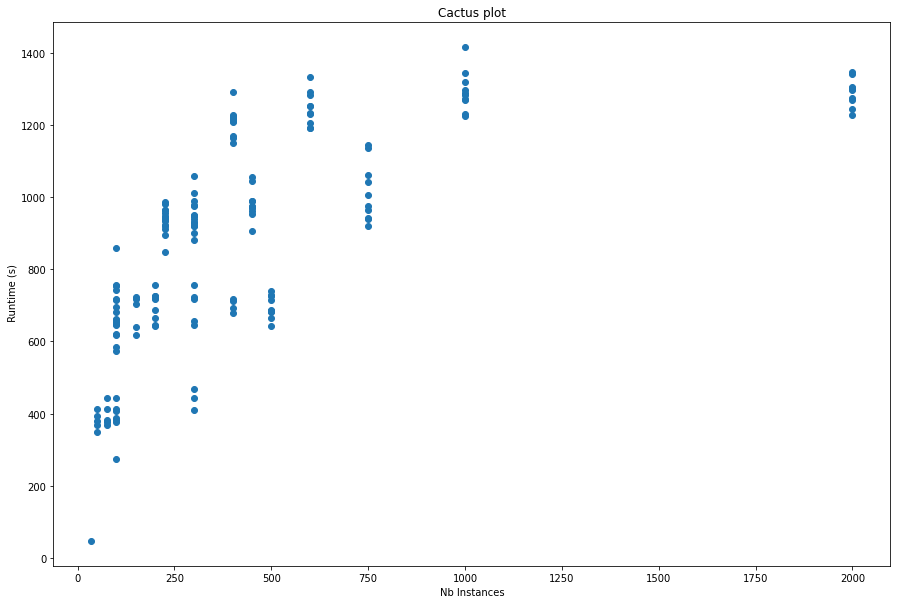

In [34]:
plt.figure(figsize=(15, 10))
plt.scatter(Instances, Duration, )
plt.xlabel("Nb Instances")
plt.ylabel(" Runtime (s)")
plt.title("Cactus plot")

Text(0.5, 1.0, 'Cactus plot')

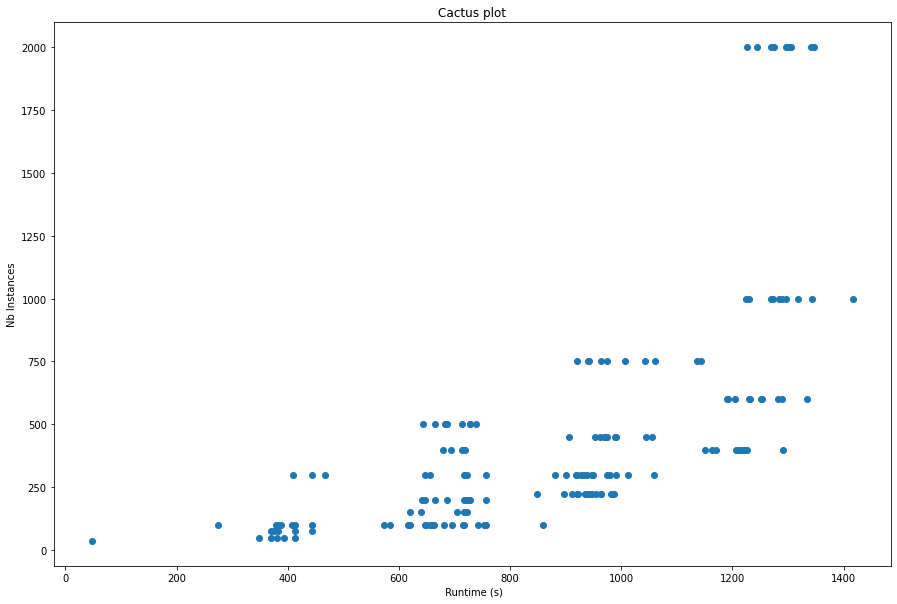

In [23]:
plt.figure(figsize=(15, 10))
plt.scatter(Duration, Instances)
plt.ylabel("Nb Instances")
plt.xlabel(" Runtime (s)")
plt.title("Cactus plot")

## 4. Conclusion

**Question:** What did you learn loday? 

In this notebook we have dealt with a problem called scheduling. These are common problems in everyday life. In our case, we had to deal with tasks performed by different machines, the so-called job shop scheduling problem. The goal was to manage 2 constraints:

* precedence type constraints. This is to manage the constraint that each task is processed in a specific order to meet expectations.
* disjunction constraints, which are translated by the fact that each machine can perform only one task at a time.
All of this is aimed at minimizing the processing time of all tasks.

Here it was necessary to manage a matrix presenting the tasks with each time the machines and the associated times. To do this, we created a matrix that recovers the order of the machines for each task and another one that recovers the time of the tasks associated with the machines.

First, we created our model as well as time intervals associated to the work on a machine. Here we do this because we can't work just with whole time values. These intervals represent the running time of a machine on a task on a time scale from 0 to the UpperBound. This UpperBound is calculated as the maximum processing time of the tasks (we took the sum of all times in "sequential" mode).

Then we managed the order constraints of the machines on each task but also the fact that a machine can only work on one task at a time. For this we created 2 matrices:

* one on the order constraints of a task (per_jobs). we go through the lines of our time matrix and we create constraints one by one i.e. that the work of the machine in 1st position of task 1 must be done and finished before the machine in 2nd position starts and so on until the end of the task. This was handled by the "end_before_start" function.
* the other being the one that will manage the work of each machine on all tasks (per_machs). For example, for machine 1, its work on task 1 must be finished before it can start the work on the next task. This has been handled with the "no_overlap" function which means that there must be no overlap.
Then we added all the constraints to the model and created a "makespan" which is the objective function. This function returns the maximum processing time between all tasks.

And finally we solve the problem.

We had a problem with the creation of interval_var(start=(0, upper_bound), end=(0, upper_bound)). At the beginning we had set interval_var(start=0, end=upper_bound) which actually forced all the processing of the tasks to start and finish at the same time. Whereas with our modification, they can start whenever they want on the interval (0,upper_bound).

In the end we find a solution of 47 which is rather interesting because our UpperBound was 197 in "sequential" mode. All this allowed us to understand the intra and inter task dependencies.

And finally, we created a function summarizing all this and allowing us to process all possible types of input data. (see cactus plot above)